# Forestry ARR Eligibility - GEE AND STAC Approach

This notebook demonstrates the STAC-based approach for forestry ARR eligibility analysis when historical Sentinel data is not available from Google Earth Engine.

## 📦 Required Libraries Installation

Before running this notebook, install the required libraries:

```bash
# Core STAC and GEE-xarray integration (REQUIRED)
pip install xarray>=2023.1.0 rioxarray>=0.15.0 xee>=0.0.8

# STAC client libraries
pip install planetary-computer>=0.4.0 pystac-client>=0.7.0 stackstac>=0.4.0

# Optional but recommended for better performance
pip install dask>=2023.1.0
```

Or install all at once:
```bash
pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask
```

**Note:** `xarray` and `xee` are **required dependencies** - they enable Google Earth Engine integration with xarray for time series processing.

In [1]:
# Install required libraries for STAC processing
# Uncomment the line below if libraries are not installed
# !pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask

# Verify installation - xarray and xee are REQUIRED
required_libs = {
    'xarray': 'xarray',  # REQUIRED - core dependency
    'rioxarray': 'rioxarray',  # REQUIRED - for geospatial raster operations
    'xee': 'xee',  # REQUIRED - Google Earth Engine to xarray bridge
    'planetary_computer': 'planetary-computer',  # For STAC access
    'pystac_client': 'pystac-client',  # For STAC client
    'stackstac': 'stackstac',  # For stacking STAC items
    'geopandas': 'geopandas',  # Core geospatial library
    'geemap': 'geemap'  # Optional - for GEE visualization
}

critical_libs = ['xarray', 'rioxarray', 'xee']  # Must-have libraries
missing_libs = []
missing_critical = []

for module_name, package_name in required_libs.items():
    try:
        __import__(module_name)
        status = "⭐" if module_name in critical_libs else "✅"
        print(f"{status} {module_name} is installed")
    except ImportError:
        status = "🚨" if module_name in critical_libs else "❌"
        print(f"{status} {module_name} is MISSING - install with: pip install {package_name}")
        missing_libs.append(package_name)
        if module_name in critical_libs:
            missing_critical.append(package_name)

if missing_critical:
    print(f"\n🚨 CRITICAL: Missing required libraries! Install them with:")
    print(f"   pip install {' '.join(missing_critical)}")
    raise ImportError(f"Required libraries missing: {', '.join(missing_critical)}")
elif missing_libs:
    print(f"\n⚠️ Missing optional libraries. Install them with:")
    print(f"   pip install {' '.join(missing_libs)}")
else:
    print("\n✅ All required libraries are installed!")


⭐ xarray is installed
⭐ rioxarray is installed
⭐ xee is installed
✅ planetary_computer is installed
✅ pystac_client is installed
✅ stackstac is installed
✅ geopandas is installed
✅ geemap is installed

✅ All required libraries are installed!


In [2]:
# !pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask

In [3]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR

# Initialize Forestry Carbon ARR system
forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
from_gee_version_1_config = forestry.config

/opt/venv/lib/python3.12/site-packages/gcsfs/core.py:317: UserWarning: GCS project not set - cannot list or create buckets
  warnings.warn("GCS project not set - cannot list or create buckets")


In [4]:
from_gee_version_1_config

{'project': {'name': 'forestry_carbon_project',
  'region': 'asia',
  'description': 'Forestry Carbon ARR Analysis Project',
  'version': '1.0.0'},
 'gee': {'project_id': None,
  'service_account': None,
  'initialize': True,
  'max_pixels': 10000000000000.0,
  'scale': 30,
  'crs': 'EPSG:4326'},
 'satellite': {'provider': 'Custom',
  'date_range': ['2025-8-1', '2025-8-31'],
  'cloud_cover_threshold': 80,
  'bands': {'Sentinel': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
   'Planet': ['red', 'green', 'blue', 'nir'],
   'Landsat': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']},
  'composite_method': 'median',
  'mask_clouds': True},
 'ml': {'algorithm': 'gbm',
  'training_samples': 1000,
  'validation_split': 0.2,
  'cross_validation': True,
  'n_folds': 5,
  'random_state': 42,
  'hyperparameter_tuning': True},
 'fcd': {'method': 'pca',
  'thresholds': {'high_forest': 65,
   'yrf_forest': 45,
   'shrub_grass': 45,
   'open_land': 30},
  'apply_smoothing': True,
  'smoothing_kernel': 3},
 'classifi

In [5]:
### START TO WORK WITH STAC, check availability of historical sentinel data
import json
import geopandas as gpd
config = from_gee_version_1_config

#INPUT VARIABLES
is_export_image_to_drive = False

aoi_gpd = gpd.GeoDataFrame.from_file(config["AOI_path"])
aoi_gpd = aoi_gpd.to_crs(epsg=int(config['gee']["crs"].split(":")[-1])) # satellite crs is epsg code of projected UTM crs
if aoi_gpd.crs.to_string() == 'EPSG:4326':
    aoi_gpd = aoi_gpd.to_crs(epsg=3857)

aoi_ha = aoi_gpd.geometry.area.sum()/10000
print('area: (Ha) ', aoi_ha)

area: (Ha)  145272.7744003245


In [6]:
config

{'project': {'name': 'forestry_carbon_project',
  'region': 'asia',
  'description': 'Forestry Carbon ARR Analysis Project',
  'version': '1.0.0'},
 'gee': {'project_id': None,
  'service_account': None,
  'initialize': True,
  'max_pixels': 10000000000000.0,
  'scale': 30,
  'crs': 'EPSG:4326'},
 'satellite': {'provider': 'Custom',
  'date_range': ['2025-8-1', '2025-8-31'],
  'cloud_cover_threshold': 80,
  'bands': {'Sentinel': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
   'Planet': ['red', 'green', 'blue', 'nir'],
   'Landsat': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']},
  'composite_method': 'median',
  'mask_clouds': True},
 'ml': {'algorithm': 'gbm',
  'training_samples': 1000,
  'validation_split': 0.2,
  'cross_validation': True,
  'n_folds': 5,
  'random_state': 42,
  'hyperparameter_tuning': True},
 'fcd': {'method': 'pca',
  'thresholds': {'high_forest': 65,
   'yrf_forest': 45,
   'shrub_grass': 45,
   'open_land': 30},
  'apply_smoothing': True,
  'smoothing_kernel': 3},
 'classifi

In [7]:
from forestry_carbon_arr.core.utils import DataUtils

d = DataUtils(config)
aoi_gpd, aoi_ee = d.load_geodataframe_gee(config["AOI_path"])

# we shall use the STAC approach if historical data of sentinel is not available from GEE 
# first we need to check in the AOI, date range availability, and do the historical data similar to the Hansen approach

# We should change the use_gee = True as use_hansen_gee = True vs use_tsfresh = True
# use_hansen_gee = True, is the first version of eligibility check that use landcover, and hansen tree cover
# use_tsfresh = True, is the second version of eligibility check that use tsfresh to extract the features from the time series of satellite data (replacing hansen) and current model will at the moment use 
## trees vs non-trees classification in use_tsfresh

# check the date range availability of the sentinel data - GEE xee, let's leverage the GEE with xarray,
from gee_lib.osi.image_collection.main import ImageCollection

# Create configuration for GEE ImageCollection

year_end = int(config['date_start_end'][1].split('-')[0])
ten_years_prior = year_end -10

new_date_start_end = [f'{ten_years_prior}-01-01', f"{config['date_start_end'][1]}"]

gee_config = {
    'AOI': aoi_ee,
    'date_start_end': new_date_start_end,
    'cloud_cover_threshold': config['satellite']['cloud_cover_threshold'],
    'config': {'IsThermal': False}
}

# Initialize ImageCollection
image_collection = ImageCollection(
    I_satellite=config['I_satellite'],
    region=aoi_gpd,
    **gee_config
)

# Get the raw ImageCollection (not mosaicked)
raw_collection = image_collection.image_collection_mask()
## masking cloud, get xarray with applied cloud mask

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [8]:
#### adding the existing analysis as the loaded data result, after initialization
asset_folder = 'projects/remote-sensing-476412/assets/korindo_sentinel2_monthly'  # Change to your asset path
use_aset = True
if use_aset:
    monthly_mosaick = ee.ImageCollection(asset_folder)

## Step 2: Convert to UTM CRS (meters)

**Why UTM?**
- UTM uses meters as units (not degrees like EPSG:4326)
- Scale parameter in xee should match CRS units
- Sentinel-2: 10m pixels means 10 meters, which only makes sense in UTM
- Better for spatial analysis and area calculations

**Steps:**
1. Determine UTM zone from AOI centroid longitude
2. Reproject raw_collection in Earth Engine to UTM
3. Update xee parameters to use UTM CRS and meter scale


In [9]:
# Step 1: Determine UTM zone from AOI centroid
# UTM zones are calculated based on longitude: zone = floor((lon + 180) / 6) + 1

import numpy as np

# Get centroid longitude (must be in WGS84/ EPSG:4326 for UTM calculation)
if aoi_gpd.crs.to_string() != 'EPSG:4326':
    aoi_wgs84 = aoi_gpd.to_crs('EPSG:4326')
else:
    aoi_wgs84 = aoi_gpd

centroid_lon = aoi_wgs84.geometry.centroid.x.mean()
centroid_lat = aoi_wgs84.geometry.centroid.y.mean()

# Calculate UTM zone
utm_zone = int(np.floor((centroid_lon + 180) / 6)) + 1

# Determine hemisphere (N or S) based on latitude
hemisphere = 'N' if centroid_lat >= 0 else 'S'

# UTM EPSG code format: EPSG:326XX (northern) or EPSG:327XX (southern)
if hemisphere == 'N':
    utm_epsg = 32600 + utm_zone  # Northern hemisphere
else:
    utm_epsg = 32700 + utm_zone  # Southern hemisphere

print(f"📍 AOI Centroid: ({centroid_lat:.4f}°, {centroid_lon:.4f}°)")
print(f"🗺️  UTM Zone: {utm_zone}{hemisphere}")
print(f"🔢 UTM EPSG Code: EPSG:{utm_epsg}")
print(f"📐 CRS Units: Meters (✅ matches scale units)")

# Update config with UTM CRS
config['utm_crs'] = f'EPSG:{utm_epsg}'
config['utm_zone'] = utm_zone
config['utm_hemisphere'] = hemisphere


📍 AOI Centroid: (-0.3125°, 111.9082°)
🗺️  UTM Zone: 49S
🔢 UTM EPSG Code: EPSG:32749
📐 CRS Units: Meters (✅ matches scale units)


/tmp/ipykernel_860/3455030237.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon = aoi_wgs84.geometry.centroid.x.mean()
/tmp/ipykernel_860/3455030237.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lat = aoi_wgs84.geometry.centroid.y.mean()


In [10]:
if config['I_satellite'] == 'Sentinel':
        pixel_scale = 10  # meters for Sentinel-2
elif config['I_satellite'] == 'Landsat':
    pixel_scale = 30  # meters for Landsat
else:
    pixel_scale = 10  # default
    
if use_aset == False:
    # Step 2: Reproject raw_collection to UTM in Earth Engine
    # This ensures the ImageCollection is in meters before xee conversion

    print("🔄 Reprojecting raw_collection to UTM...")

    # Reproject each image in the collection to UTM
    # scale: pixel size in meters (10m for Sentinel-2)
    # crs: UTM EPSG code

    # Reproject the collection
    raw_collection_utm = raw_collection.map(
        lambda image: image.reproject(
            crs=f'EPSG:{utm_epsg}',
            scale=pixel_scale
        )
    )

    print(f"✅ Reprojected to {config['utm_crs']}")
    print(f"   Scale: {pixel_scale}m (matches CRS units)")

    # Update the collection variable
    raw_collection = raw_collection_utm

else:
    print("🔄 Using existing asset collection")


🔄 Using existing asset collection


In [11]:
import ee
import numpy as np

# Step 2: Check the raw_collection structure
print("📊 Raw Collection Info:")
print(f"Type: {type(raw_collection)}")
print(f"Is ImageCollection: {isinstance(raw_collection, ee.ImageCollection)}")

# Step 3: Get the AOI bounding box in UTM (required for xee)
# First, transform aoi_ee geometry to UTM so bounds are in meters
print(f"\n🔄 Converting AOI geometry to UTM ({config['utm_crs']})...")
aoi_gpd_utm = aoi_gpd.to_crs(f'EPSG:{utm_epsg}')
aoi_gpd_utm.set_crs(f'EPSG:{utm_epsg}', inplace=True)

# aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm) # not possible, uploaded fc will automatically 4326

# # Get bounds from UTM geometry (now in meters)
# aoi_bounds_utm = aoi_ee_utm_geom.bounds().getInfo()
# print(f"📍 AOI Bounds (UTM): {aoi_bounds_utm}")

# # Extract the coordinates from UTM bounds
# coordinates_utm = aoi_bounds_utm['coordinates'][0]
# # xee expects region as a list: [west, south, east, north] or a GeoJSON-like dict
# # Bounds are now in meters (UTM)
# from shapely.geometry import box
# bounds_list_utm = [coordinates_utm[0][0], coordinates_utm[0][1], coordinates_utm[2][0], coordinates_utm[2][1]]
# print(f"Bounds list format [west, south, east, north] in meters: {bounds_list_utm}")
# print(f"   Note: These coordinates are in UTM meters, not degrees!")

# Also keep the UTM geometry for later use
# aoi_ee_utm = aoi_ee_utm_geom  # Save for use in xee conversion


📊 Raw Collection Info:
Type: <class 'NoneType'>
Is ImageCollection: False

🔄 Converting AOI geometry to UTM (EPSG:32749)...


,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,HECTARES,Km,width,height,area,perimeter,id,geometry
0,None,None,None,None,None,None,-1,0,-1,None,None,40022.861,400.228614,0.403343,0.290644,0.117229,1.387972,0,"POLYGON ((578614.536 9949391.122, 578616.697 9..."


In [12]:
# aoi_gpd_utm

In [13]:
# aoi_gpd_utm.geometry

In [14]:
# Step 4: Configure xee parameters for UTM
# Now we use UTM CRS (meters) which matches the scale units

# Scale is already set from previous step (10m for Sentinel-2)
print(f"📐 Pixel Scale: {pixel_scale}m ({config['I_satellite']})")

# Use UTM CRS (already calculated)
utm_crs = config['utm_crs']
print(f"🌍 CRS: {utm_crs} (UTM Zone {config['utm_zone']}{config['utm_hemisphere']})")
print(f"✅ Scale and CRS units both in meters - correct!")

# Extract EPSG code for xee
epsg_code = utm_epsg


📐 Pixel Scale: 10m (Custom)
🌍 CRS: EPSG:32749 (UTM Zone 49S)
✅ Scale and CRS units both in meters - correct!


<Axes: >

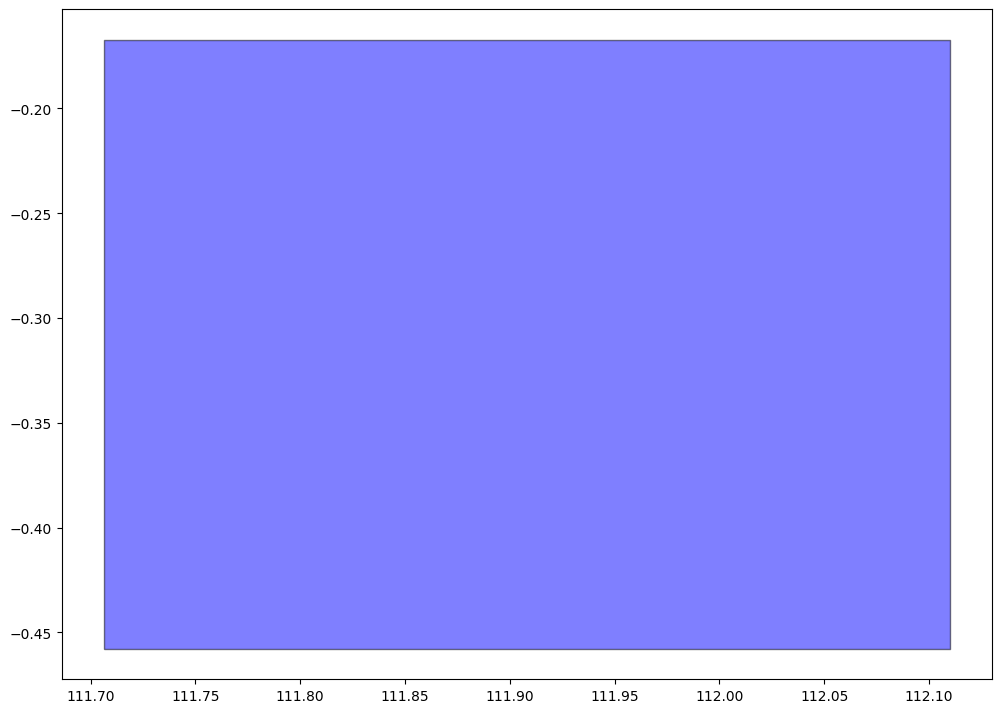

In [15]:
type(aoi_gpd)
# Simple way to plot geometry - just call .plot() method
aoi_gpd.plot(figsize=(12, 12), color='blue', edgecolor='black', alpha=0.5)

# Or use the geometry directly
# geom = aoi_gpd.geometry
# geom.plot(figsize=(10, 10), color='green', edgecolor='red', linewidth=2)


In [16]:
# display(geom)

In [17]:
pixel_scale

10

In [18]:
# raw_collection

In [19]:
# list_month_year = [f'{i}-{j}' for i in range(2015, 2025) for j in range(1, 13)]

# list_month_year
# raw_collection.filterDate()

In [20]:
if use_aset == False:
    ### FINAL FILTERING CLOUD COVER AND CLOUD MASK
    # Calculate total grid pixels using the SAME method as xarray would
    print("📐 Calculating total grid pixels (matching xarray method)...")

    # Transform geometry to UTM (same as xarray does)
    aoi_geom_utm = aoi_ee.geometry().transform(
        f'EPSG:{utm_epsg}',
        maxError=1
    )

    # Get bounding box in UTM
    aoi_bounds_utm = aoi_geom_utm.bounds(maxError=1)

    # Use a constant image to count ALL pixels in the bounding box
    # This matches exactly what xarray does: creates grid over bounding box
    scale = 10
    crs_utm = f'EPSG:{utm_epsg}'

    # ============================================================================
    # COMMENTED OUT: Previous approach using total AOI grid pixels
    # ============================================================================
    # WHY COMMENTED: Key difference between STAC (Microsoft Planetary Computer) and GEE:
    #
    # STAC/MPC BEHAVIOR:
    #   - Same tile-ID = Same scene/image (one-to-one mapping)
    #   - Each tile-ID corresponds to a single, unique scene
    #   - No mosaic processing: tile-ID uniquely identifies the scene
    #
    # GEE BEHAVIOR:
    #   - Same tile-ID = Can be split/mosaicked into multiple scenes
    #   - One tile-ID can appear in multiple images (mosaic processing)
    #   - Different processing times can create different mosaics from same tile-ID
    #   - GEE combines multiple tiles with same ID but different timestamps into mosaic
    #
    # IMPLICATION:
    #   - In STAC: Total AOI grid pixels makes sense (consistent per tile-ID)
    #   - In GEE: Need intersected pixels only (mosaic varies per processing time)
    #   - Therefore, we should NOT use total AOI as the divider, but total intersected pixels
    # ============================================================================
    # Create constant image (1 everywhere)
    # constant_img = ee.Image.constant(1)

    # Count pixels in bounding box using same parameters as xarray
    # xarray uses: geometry (transformed), crs, scale ---> we cant use the MPC xarray approach in GEE
    # total_grid_pixels_result = constant_img.reduceRegion(
    #     reducer=ee.Reducer.sum(),
    #     geometry=aoi_bounds_utm,  # Use bounding box, not polygon
    #     scale=scale,               # Same as xarray scale
    #     crs=crs_utm,              # Same as xarray CRS
    #     bestEffort=True,
    #     maxPixels=1e10
    # )

    # Get the value
    # total_grid_pixels = total_grid_pixels_result.get('constant').getInfo()
    # print(f"📊 Total grid pixels: {total_grid_pixels:,}") 
    # ============================================================================
    # END OF COMMENTED SECTION
    # ============================================================================

    # STAC I meant is the MPC (Microsoft Planetary Computer):
    #   - In MPC/STAC: Same tile-ID = same scene (no mosaic processing)
    #   - In GEE: Same tile-ID can be mosaicked but processed at different times
    # THEREFORE, WE SHOULD NOT USE THE TOTAL AOI AS THE DIVIDER, BUT THE TOTAL INTERSECTED PIXELS 
    # (No need to put NA - we count actual intersected pixels per scene)

    print(f"   Scale: {scale}m")
    print(f"   CRS: {crs_utm}")
    print(f"   ⚠️  CHANGED: Using total intersected pixels (valid + invalid) instead of total AOI grid")
    print(f"   Reason: GEE mosaics same tile-ID across different processing times, STAC keeps tile-ID unique")

    # ============================================================================
    # COMMENTED OUT: Alternative verification method
    # ============================================================================
    # This section was for debugging/verification but not needed in production
    # ============================================================================
    # # Verify it's reasonable (should be similar to 801 x 531 = 425,331)
    # if total_grid_pixels == 0:
    #     print("\n⚠️ WARNING: Could not calculate grid pixels!")
    #     print("   Trying alternative method...")
        
    #     # Alternative: use pixelLonLat to get extent
    #     sample_img = raw_collection.first().select('cloudM')
    #     lonlat = sample_img.select('cloudM').addBands(ee.Image.pixelLonLat())
        
    #     # This is more complex, so let's stick with the constant image approach
    #     # But check if geometry transform worked
    #     print("   Checking transformed geometry...")
    #     aoi_geom_utm_info = aoi_geom_utm.getInfo()
    #     print(f"   Transformed geometry: {aoi_geom_utm_info.get('type', 'unknown')}")
        
    # else:
    #     print(f"✓ Grid pixels calculated successfully!")
    # ============================================================================
    # END OF COMMENTED SECTION
    # ============================================================================

    def add_cloudm_stats(image):
        """
        Calculate cloudM percentages - only cloudM=1 is valid
        
        CHANGED: Now uses total intersected pixels (valid + invalid) as denominator
        instead of total AOI grid pixels.
        
        FIXED: Uses frequencyHistogram instead of two separate reduceRegion calls
        This reduces concurrent aggregations by 50% (one call instead of two)
        
        FIXED: Properly handles ee.Dictionary.get() return values by converting to ee.Number
        
        This accounts for GEE mosaic processing where:
        - Same tile-ID can appear in multiple scenes (mosaicked at different times)
        - STAC/MPC: Same tile-ID = same scene (no mosaic)
        - GEE: Same tile-ID = can be mosaicked but processed at different times
        """
        cloudm_band = image.select('cloudM')
        
        # FIXED: Use frequencyHistogram to get both 0 and 1 counts in ONE reduceRegion call
        # This reduces concurrent aggregations by 50% compared to two separate calls
        # Histogram returns dict like {'0': count0, '1': count1}
        histogram = cloudm_band.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=aoi_bounds_utm,  # Bounding box (matches xarray grid extent)
            scale=scale,              # Same as xarray
            crs=crs_utm,             # Same as xarray
            bestEffort=True,
            maxPixels=1e11
        ).get('cloudM')
        
        # FIXED: Extract counts from histogram dictionary properly
        # Handle case where histogram might be None or missing values
        # Use plain number (0) as default, then convert to ee.Number
        hist_dict = ee.Dictionary(histogram)
        count_0_raw = hist_dict.get('0', 0)  # Invalid/cloudy pixels - use plain 0, not ee.Number(0)
        count_1_raw = hist_dict.get('1', 0)  # Valid pixels - use plain 0, not ee.Number(0)
        
        # Convert to ee.Number explicitly (handles both plain numbers and ComputedObjects)
        count_0 = ee.Number(count_0_raw)
        count_1 = ee.Number(count_1_raw)
        
        # CHANGED: Calculate percentage using total intersected pixels
        # OLD: pct_valid = ee.Number(count_valid).divide(total_grid_pixels).multiply(100)
        # NEW: Use sum of valid + invalid (only intersected pixels, not full AOI grid)
        # Reason: GEE mosaics same tile-ID across different processing times,
        #         so we need per-scene intersected pixels, not total AOI grid
        sum_pixels = count_0.add(count_1)
        pct_valid = count_1.divide(sum_pixels).multiply(100)
        
        # ADDED: Store additional stats for debugging
        return image.set({
            'cloudM_pct_valid': pct_valid,
            'cloudM_count_valid': count_1,
            'cloudM_count_invalid': count_0,
            'cloudM_total_intersected': sum_pixels
        })

    # Get valid pixel threshold with error handling
    # ADDED: Default value if not in config
    valid_pixel_threshold = config.get('valid_pixel_threshold', 70)

    # Add statistics
    print("\n🔄 Calculating cloudM statistics for each scene...")
    collection_with_stats = raw_collection.map(add_cloudm_stats)

    # Get statistics
    print("📊 Computing statistics...")
    pct_array = collection_with_stats.aggregate_array('cloudM_pct_valid').getInfo()
    pct_array = [float(x) if x is not None else 0.0 for x in pct_array]

    # Print same format as xarray version
    # IMPROVED: Added mean and better formatting
    if len(pct_array) > 0:
        print(f"\nValid pixel percentages: min={min(pct_array):.1f}%, max={max(pct_array):.1f}%")
        print(f"Mean: {sum(pct_array)/len(pct_array):.1f}%")
        
        n_valid = sum(1 for p in pct_array if p > valid_pixel_threshold)
        n_total = len(pct_array)
        print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {n_valid}/{n_total}")
        
        # ADDED: Warning if no scenes pass threshold
        if n_valid == 0:
            print(f"\n⚠️  WARNING: No scenes passed the threshold!")
            print(f"   Consider lowering valid_pixel_threshold (current: {valid_pixel_threshold}%)")
    else:
        print("\n⚠️  WARNING: No statistics computed!")

    # Filter
    collection_filtered = collection_with_stats.filter(
        ee.Filter.gt('cloudM_pct_valid', valid_pixel_threshold)
    )

    # Get sizes
    original_size = raw_collection.size().getInfo()
    filtered_size = collection_filtered.size().getInfo()

    print(f"\nAfter valid pixel filtering:")
    print(f"  Filtered: {filtered_size} scenes")
    print(f"  Removed: {original_size - filtered_size} scenes")
    # IMPROVED: Added retention rate
    print(f"  Retention rate: {(filtered_size/original_size*100):.1f}%")

    # collection_with_eemont_indices = collection_filtered
    # collection_filtered.size().getInfo()
else:
    print("🔄 Using existing asset collection")

🔄 Using existing asset collection


In [21]:
## UNCOMMENT TO GET INFO ABOUT DATA AVAILABILITY
# # Method 1: Get dates using system:time_start (most common)
# dates_timestamps = collection_filtered.aggregate_array('system:time_start').getInfo()

# # Convert timestamps (milliseconds) to Python datetime objects
# import datetime
# dates_list = [datetime.datetime.fromtimestamp(ts / 1000) for ts in dates_timestamps]

# # Or as date strings
# dates_str_list = [datetime.datetime.fromtimestamp(ts / 1000).strftime('%Y-%m-%d') for ts in dates_timestamps]

# print(f"Total dates: {len(dates_list)}")
# print(f"Date range: {dates_list[0]} to {dates_list[-1]}")
# print(f"Dates: {dates_str_list}")

# ## data availability
# start_date = dates_list[0]
# end_date = dates_list[-1]

# print(f"Data availability: {start_date} to {end_date}")

# start_year = start_date.year
# end_year = end_date.year

# print(f"Year range: {start_year} to {end_year}")

# # check if all year has the representative image

# for i in range(start_year, end_year + 1):
#     if i not in [date.year for date in dates_list]:
#         print(f"Year {i} does not have a representative image")
#     else:
#         print(f"Year {i} has a representative image")


In [22]:
# import pandas as pd

# print("📅 Creating quarterly composites...")

# # Get date list (for the initial info)
# dates_list = collection_filtered.aggregate_array('system:time_start').getInfo()
# print(f"   Input: collection_filtered ({len(dates_list)} scenes)")
# print(f"   Output: Quarterly composites (every 3 months, end-of-quarter dates)")

# # ------------------------------------------------------------------
# # STEP 1 — build quarterly ee.Image objects, keep them in a Python list
# # ------------------------------------------------------------------
# quarterly_images = []

# # Pre-compute available years so we can print them
# years = sorted({pd.Timestamp(ts, unit='ms').year for ts in dates_list})

# for year in years:
#     for quarter in [1, 2, 3, 4]:
#         # Quarter start/end
#         start_month = (quarter - 1) * 3 + 1
#         start = ee.Date.fromYMD(year, start_month, 1)
#         end = start.advance(3, 'month').advance(-1, 'day')

#         quarter_collection = collection_filtered.filterDate(start, end.advance(1, 'day'))

#         count = quarter_collection.size().getInfo()
#         if count == 0:
#             continue

#         composite = quarter_collection.reduce(ee.Reducer.median()) \
#             .set({
#                 'system:time_start': end.millis(),
#                 'year': year,
#                 'quarter': quarter,
#                 'n_images': count,
#                 'system:id': f'Sentinel2_{year}_q{quarter}'
#             }).clip(aoi_ee.geometry())

#         quarterly_images.append(composite)
#         print(f"   Q{quarter} {year}: {count} images → composite (ID: Sentinel2_{year}_q{quarter}, Date: {end.format('YYYY-MM-dd').getInfo()})")

# print(f"\n✅ Step 1 complete; built {len(quarterly_images)} quarterly images (stored client-side as ee.Image objects)")

# # ------------------------------------------------------------------
# # STEP 2 — assemble ImageCollection and print summary (keep existing prints)
# # ------------------------------------------------------------------
# collection_quarterly = ee.ImageCollection(quarterly_images) \
#     .filterMetadata('n_images', 'greater_than', 0) \
#     .sort('system:time_start')

# n_quarters = collection_quarterly.size().getInfo()
# print(f"\n✅ Quarterly aggregation complete!")
# print(f"   Number of quarterly composites: {n_quarters}")

# if n_quarters > 0:
#     quarterly_dates = collection_quarterly.aggregate_array('system:time_start').getInfo()
#     quarterly_dates_str = [pd.Timestamp(ts, unit='ms').strftime('%Y-%m-%d') for ts in quarterly_dates]

#     quarterly_ids = collection_quarterly.aggregate_array('system:id').getInfo()

#     print(f"\n📊 Quarterly composites:")
#     for i, (date_str, q_id) in enumerate(zip(quarterly_dates_str, quarterly_ids), 1):
#         print(f"   {i}. {q_id}: {date_str}")

#     sample_quarter = collection_quarterly.first()
#     sample_info = {
#         'id': sample_quarter.get('system:id').getInfo(),
#         'year': sample_quarter.get('year').getInfo(),
#         'quarter': sample_quarter.get('quarter').getInfo(),
#         'n_images': sample_quarter.get('n_images').getInfo(),
#         'date': pd.Timestamp(sample_quarter.get('system:time_start').getInfo(), unit='ms').strftime('%Y-%m-%d'),
#     }
#     print(f"\n   Sample composite: {sample_info}")

In [23]:
if use_aset == False:
    import pandas as pd

    print("📅 Creating monthly composites...")

    # Get date list (for the initial info)
    dates_list = collection_filtered.aggregate_array('system:time_start').getInfo()
    print(f"   Input: collection_filtered ({len(dates_list)} scenes)")
    print(f"   Output: Monthly composites (each month stamped at the 15th)")

    # ------------------------------------------------------------------
    # STEP 1 — build monthly ee.Image objects and keep them in a Python list
    # ------------------------------------------------------------------
    monthly_images = []

    # Pre-compute available months per year from the collection's dates
    dates_df = pd.DataFrame({
        'timestamp': dates_list,
        'date': pd.to_datetime(dates_list, unit='ms')
    })
    dates_df['year'] = dates_df['date'].dt.year
    dates_df['month'] = dates_df['date'].dt.month

    # Sort by year, month
    unique_year_month = sorted(
        {(row.year, row.month) for row in dates_df.itertuples()}
    )

    for year, month in unique_year_month:
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month').advance(-1, 'day')  # end of month

        month_collection = collection_filtered.filterDate(start, end.advance(1, 'day'))
        count = month_collection.size().getInfo()
        if count == 0:
            continue

        # Timestamp at mid-month (15th)
        mid = ee.Date.fromYMD(year, month, 15)

        composite = month_collection.reduce(ee.Reducer.median()) \
            .set({
                'system:time_start': mid.millis(),
                'year': year,
                'month': month,
                'n_images': count,
                'system:id': f'Sentinel2_{year}_{month:02d}'
            }).clip(aoi_ee.geometry())

        monthly_images.append(composite)
        print(f"   {year}-{month:02d}: {count} images → composite "
            f"(ID: Sentinel2_{year}_{month:02d}, Date stamp: {mid.format('YYYY-MM-dd').getInfo()})")

    print(f"\n✅ Step 1 complete; built {len(monthly_images)} monthly images (stored client-side as ee.Image objects)")
else:
    print("🔄 Using existing asset collection")

🔄 Using existing asset collection


In [24]:
#### IT TAKES TOO HEAVY TO RUN THIS STEP IN SERVER SIDE
# # ------------------------------------------------------------------
# # STEP 2 — assemble ImageCollection and print summary (keep existing prints)
# # ------------------------------------------------------------------
# collection_monthly = ee.ImageCollection(monthly_images) \
#     .filterMetadata('n_images', 'greater_than', 0) \
#     .sort('system:time_start')

# n_months = collection_monthly.size().getInfo()
# print(f"\n✅ Monthly aggregation complete!")
# print(f"   Number of monthly composites: {n_months}")

# if n_months > 0:
#     monthly_dates = collection_monthly.aggregate_array('system:time_start').getInfo()
#     monthly_dates_str = [pd.Timestamp(ts, unit='ms').strftime('%Y-%m-%d') for ts in monthly_dates]

#     monthly_ids = collection_monthly.aggregate_array('system:id').getInfo()

#     print(f"\n📊 Monthly composites:")
#     for i, (date_str, m_id) in enumerate(zip(monthly_dates_str, monthly_ids), 1):
#         print(f"   {i}. {m_id}: {date_str}")

#     sample_month = collection_monthly.first()
#     sample_info = {
#         'id': sample_month.get('system:id').getInfo(),
#         'year': sample_month.get('year').getInfo(),
#         'month': sample_month.get('month').getInfo(),
#         'n_images': sample_month.get('n_images').getInfo(),
#         'date': pd.Timestamp(sample_month.get('system:time_start').getInfo(), unit='ms').strftime('%Y-%m-%d'),
#     }
#     print(f"\n   Sample composite: {sample_info}")

In [25]:
# import os
# import geemap

# Map = geemap.Map(ee_initialize=False)
# Map.add_layer(collection_quarterly.first(), {}, 'First image')
# Map.add_layer(aoi_ee.geometry(), {}, 'AOI')
# Map.centerObject(aoi_ee.geometry(), 10)
# Map


In [26]:
## skip this in gcp environment, we already see that its there
# from wfs_manager import WFSManager

# wfs = WFSManager(fastapi_url="http://fastapi:8000", wfs_base_url="http://localhost:8001")
# wfs.addLayer(aoi_ee.geometry(), "AOI Boundary")
# wfs.publish()

In [27]:
# monthly_images

In [28]:
######### ONLY ONE TIME TO EXPORT TO MAKE PROCESS FASTER LATER TO USE THE ASSETS!
### LETS EXPORT FIRST THE ee.ImageCollection (Computed --> Quarterly data)
# After collection_quarterly is built
scale = 10
region = aoi_ee.geometry()

if use_aset == False:
    len_monthly_images = len(monthly_images)
    print(f"Submitting {len_monthly_images} export tasks...")

    for i, image in enumerate(monthly_images):
        image_id = image.get('system:id').getInfo()  # e.g. Sentinel2_2024_q1
        asset_id = f'{asset_folder}/{image_id}'

        # Ensure unique description; use .format() or f-string
        task = ee.batch.Export.image.toAsset(
            image=image,
            description=f'export_{image_id}',
            assetId=asset_id,
            scale=scale,
            region=region,
            maxPixels=1e13
        )
        task.start()
        print(f'  🚀 Started export: {asset_id}')

    print('All tasks submitted; monitor them in the Tasks tab.')

else:
    print("🔄 Using existing asset collection")


🔄 Using existing asset collection


In [29]:
print('PLEASE WAIT FOR THE ASSET TO BE UPLOADED TO GEE ASSET')

PLEASE WAIT FOR THE ASSET TO BE UPLOADED TO GEE ASSET


In [30]:
aug_img = monthly_mosaick.filterDate('2025-8-1','2025-8-31')
aug_img.size().getInfo()


1

In [31]:
## skip this for gcp docker environment (visual is not needed yet into fastapi)
# from wmts_manager import WMTSManager

# wmts = WMTSManager(project_name=config['project']['name'], aoi=aoi_ee.geometry())
# # wmts.addLayer(collection_quarterly.first(), {'bands': ['swir2_median', 'nir_median', 'red_median'],
# #    'min': 0,
# #    'max': 0.6,
# #    'gamma': 1.5}, collection_quarterly.first().get('system:id').getInfo())

# # sen_2025_q3 = ee.Image(collection_quarterly.filter(ee.Filter.eq('system:id', 'Sentinel2_2025_q3')).first())
# sen_2025_aug = aug_img.first()

# img_vis_params = {'bands': ['swir2_median', 'nir_median', 'red_median'],
#    'min': 0,
#    'max': 0.6,
#    'gamma': 1.5}

# wmts.addLayer( sen_2025_aug,img_vis_params , sen_2025_aug.get('system:id').getInfo())

# wmts.publish()

In [32]:
# config

In [33]:
monthly_mosaick.first().bandNames().getInfo()

['blue_median',
 'green_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'nir_median',
 'redE4_median',
 'swir1_median',
 'swir2_median',
 'cloudM_median']

In [34]:
list_band_names = [band for band in monthly_mosaick.first().bandNames().getInfo() if 'cloudM' not in band]
clean_band_names = [band.replace('_median', '') for band in list_band_names]
clean_band_names

['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2']

In [35]:
### no need to get cloudM median anymore, and all _median suffix should be removed
# Add Spectral Indices to ImageCollection
monthly_mosaick_cloud_free = monthly_mosaick.map(lambda img: img.select(list_band_names,clean_band_names))
monthly_mosaick_cloud_free.first().bandNames().getInfo()

['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2']

In [36]:
# Add Spectral Indices to ImageCollection
# Map spectral indices over each image in the collection using SpectralAnalysis

from gee_lib.osi.spectral_indices.spectral_analysis import SpectralAnalysis

print("🔄 Adding spectral indices to ImageCollection...")
print(f"   Satellite: {config['I_satellite']}")
print("   Mapping indices over each image in collection...")

# Prepare config for SpectralAnalysis
spectral_config = {
    'I_satellite': config['I_satellite'],
    'AOI': aoi_ee.geometry(),  # Use the AOI geometry
    'pca_scaling': config.get('pca_scaling', 1),
    'tileScale': config.get('tileScale', 2)
}

# Define function to add spectral indices to a single image
def add_spectral_indices(image):
    """
    Add spectral indices to a single image using SpectralAnalysis.
    
    Available indices based on satellite type:
    - All: NDVI, NDWI, MSAVI2, MTVI2, VARI
    - Sentinel/Landsat: BSI (requires swir1)
    Note: AVI and SI require max_bands per image (expensive), typically calculated on mosaics
    """
    # Create SpectralAnalysis instance for this image
    spectral = SpectralAnalysis(image, spectral_config)
    
    # Start with original image
    image_with_indices = image
    
    # Add simple indices (no max_bands calculation needed)
    ndvi = spectral.NDVI_func()
    ndwi = spectral.NDWI_func()
    msavi2 = spectral.MSAVI2_func()
    mtvi2 = spectral.MTVI2_func()
    vari = spectral.VARI_func()
    
    image_with_indices = image_with_indices.addBands([ndvi, ndwi, msavi2, mtvi2, vari])
    
    # Add BSI for Sentinel/Landsat (requires swir1)
    if config['I_satellite'] in ['Sentinel', 'Landsat']:
        try:
            bsi = spectral.BSI_func()
            image_with_indices = image_with_indices.addBands(bsi)
        except:
            # BSI requires swir1 - skip if not available
            pass
    
    return image_with_indices

# Map the function over the ImageCollection
collection_filtered = monthly_mosaick_cloud_free
collection_with_indices = collection_filtered.map(add_spectral_indices)

print("✅ Spectral indices added to ImageCollection!")
print("   Added: NDVI, NDWI, MSAVI2, MTVI2, VARI")
if config['I_satellite'] in ['Sentinel', 'Landsat']:
    print("   (BSI added if swir1 band available)")

# Get info about bands in first image
first_image = ee.Image(collection_with_indices.first())
band_names = first_image.bandNames().getInfo()
print(f"\n📊 First image now has {len(band_names)} bands:")
print(f"   Bands: {', '.join(band_names[:15])}{'...' if len(band_names) > 15 else ''}")

🔄 Adding spectral indices to ImageCollection...
   Satellite: Custom
   Mapping indices over each image in collection...
✅ Spectral indices added to ImageCollection!
   Added: NDVI, NDWI, MSAVI2, MTVI2, VARI

📊 First image now has 15 bands:
   Bands: blue, green, red, redE1, redE2, redE3, nir, redE4, swir1, swir2, NDVI, ndwi, msavi2, MTVI2, VARI


In [37]:
# Add FCD-related indices to ImageCollection
# 
# Simplified Forest Canopy Density (FCD) Proxy Approach
# 
# This approach uses simplified vegetation density indicators as proxies for FCD
# when full PCA-based FCD calculation is computationally prohibitive per image.
# 
# Source Literature for Simplified Approach:
# 1. Tucker, C. J. (1979). Red and photographic infrared linear combinations for monitoring vegetation. 
#    Remote Sensing of Environment, 8(2), 127-150.
#    https://doi.org/10.1016/0034-4257(79)90013-0
#    (NDVI foundation and vegetation monitoring)
#
# 2. Gao, B. C. (1996). NDWI—A normalized difference water index for remote sensing of vegetation 
#    liquid water from space. Remote Sensing of Environment, 58(3), 257-266.
#    https://doi.org/10.1016/S0034-4257(96)00067-3
#    (NDWI for water/vegetation discrimination)
#
# 3. Huete, A., Didan, K., Miura, T., Rodriguez, E. P., Gao, X., & Ferreira, L. G. (2002). 
#    Overview of the radiometric and biophysical performance of the MODIS vegetation indices. 
#    Remote Sensing of Environment, 83(1-2), 195-213.
#    https://doi.org/10.1016/S0034-4257(02)00096-2
#    (Enhanced vegetation indices and density proxies)
#
# 4. Gitelson, A. A., Kaufman, Y. J., & Merzlyak, M. N. (1996). Use of a green channel in remote 
#    sensing of global vegetation from EOS-MODIS. Remote Sensing of Environment, 58(3), 289-298.
#    https://doi.org/10.1016/S0034-4257(96)00072-7
#    (Vegetation density enhancement techniques)
#
# IMPROVED APPROACH: Pseudo Forest Canopy Density (Pseudo-FCD)
# Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
# Author: Antonio Carlon Paredes (2019)
# License: CC BY 4.0
# Reference: Azadeh ABDOLLAHNEJAD et al. "Forest canopy density assessment using different approaches"
#            Journal of Forest Science, 63, 2017 (3): 106-115
#
# This approach uses simplified versions of FCD indices without PCA:
# - NDVI (Normalized Difference Vegetation Index)
# - BI (Bare soil index) = (NIR + Green + Red) / (NIR + Green - Red)
# - SI (Shadow index) = ((1 - Green) * (1 - Red))^0.5
# - NDWI (Normalized Difference Water Index) for water detection
#
# Classification thresholds (adjustable per location):
# - High Forest: NDVI > 0.40, BI < 2, SI > 0.93
# - Low Forest: 0.20 < NDVI < 0.40, BI < 2, 0.90 < SI < 0.93
# - Grassland: NDVI > 0.20
# - Bare land: NDVI < 0.20, BI > 2, SI < 0.90
# - Water: NDWI > 0.2
#
# ============================================================================
# WHY FCD IS COMPUTATIONALLY EXPENSIVE FOR IMAGECOLLECTION MAPPING:
# ============================================================================
# 1. PCA (Principal Component Analysis) Requirements:
#    - Requires reduceRegion operations over entire AOI to compute:
#      * Mean values (mean centering)
#      * Covariance matrix (centeredCovariance reducer)
#      * Eigenvalue/eigenvector decomposition
#    - These operations scan ALL pixels in AOI per image
#    - When mapping over ImageCollection: O(n_images × AOI_pixels)
#
# 2. max_bands() Calculation (for AVI and SI):
#    - Each index (AVI, SI) requires reduceRegion(max) per band
#    - For AVI: max(red), max(green), max(blue) - 3 reduceRegion calls
#    - For SI: same 3 reduceRegion calls
#    - Per image: 6 expensive reduceRegion operations
#
# 3. normalization_100() Function:
#    - Requires reduceRegion to compute mean and stdDev
#    - Called for each band/index that needs normalization
#    - Per image: Multiple reduceRegion operations
#
# Total cost per image:
# - 1-2 PCA operations (SVI, SSI)
# - 6 reduceRegion for max_bands()
# - Multiple reduceRegion for normalization
# =~ 10+ reduceRegion operations × AOI pixel count
# ============================================================================
#
# ALTERNATIVE APPROACHES (besides current simplification):
# ============================================================================
# 1. PRE-COMPUTED STATISTICS APPROACH:
#    - Compute PCA/eigenvalues once from a representative mosaic
#    - Compute max_bands once from mosaic
#    - Apply same transformation to all images in collection
#    - Trade-off: Less accurate but 10-100x faster
#
# 2. REGIONAL NORMALIZATION APPROACH:
#    - Compute normalization parameters (mean, std) once from sample
#    - Apply fixed normalization to all images
#    - More consistent but less adaptive per-image
#
# 3. SIMPLIFIED FCD WITHOUT PCA:
#    - Use direct band combinations (e.g., NDVI * SI instead of PCA)
#    - Skip eigenvector decomposition
#    - Trade-off: Less mathematically rigorous but much faster
#
# 4. CHUNK-BASED PROCESSING:
#    - Process collection in batches
#    - Compute statistics per batch instead of per image
#    - Intermediate accuracy between per-image and global
#
# 5. APPROXIMATE PCA:
#    - Use sample-based covariance (reduceRegion on sample points)
#    - Use approximate eigen decomposition
#    - Faster but slightly less accurate
#
# Note: Full FCD calculation requires PCA which is computationally expensive per image
# This adds simplified FCD-related indices that can be calculated per image

from gee_lib.osi.spectral_indices.spectral_analysis import SpectralAnalysis
from gee_lib.osi.spectral_indices.utils import normalization_100

print("🔄 Adding FCD-related indices to ImageCollection...")
print(f"   Satellite: {config['I_satellite']}")
print("   Note: Full FCD requires PCA (expensive per image), adding simplified indices...")

# Prepare config for SpectralAnalysis
fcd_config = {
    'I_satellite': config['I_satellite'],
    'AOI': aoi_ee.geometry(),
    'pca_scaling': config.get('pca_scaling', 1),
    'tileScale': config.get('tileScale', 2)
}

def add_fcd_indices(image):
    """
    Add Pseudo Forest Canopy Density (Pseudo-FCD) indices to a single image.
    
    Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
    Uses simplified FCD indices without PCA for computational efficiency.
    Note: NDVI and NDWI are already added in spectral indices step, so we reuse them.
    """
    # Start with image that already has spectral indices
    image_with_fcd = image
    
    try:
        # Use existing NDVI and NDWI from spectral indices (don't recalculate)
        ndvi = image.select('NDVI')
        ndwi = image.select('ndwi')
        
        # BI (Bare soil index) - simplified version
        # BI = (NIR + Green + Red) / (NIR + Green - Red)
        bi = image.expression(
            '(NIR + Green + Red) / (NIR + Green - Red)', {
                'NIR': image.select('nir'),
                'Green': image.select('green'),
                'Red': image.select('red')
            }
        ).rename('BI')
        
        # SI (Shadow index) - simplified version
        # SI = ((1 - Green) * (1 - Red))^0.5
        si = image.expression(
            'pow((1 - Green) * (1 - Red), 0.5)', {
                'Green': image.select('green'),
                'Red': image.select('red')
            }
        ).rename('SI')
        
        # Add BI and SI to image
        image_with_fcd = image_with_fcd.addBands([bi, si])
        
        # Calculate continuous Pseudo-FCD percentage (0-100%)
        # Normalize proxies to [0,1] with practical ranges (tunable)
        ndvi_s = ndvi.unitScale(0.20, 0.80).clamp(0, 1)        # vegetation density
        si_s   = si.unitScale(0.90, 0.98).clamp(0, 1)          # canopy/shadow strength
        # BI high => more bare soil; invert and normalize (tune 1..3 as needed)
        bi_inv = ee.Image(1).subtract(bi.unitScale(1.0, 3.0)).clamp(0, 1)
        
        # Weighted combination (tune weights to your site)
        pseudo_fcd_0_1 = (
            ndvi_s.multiply(0.5)
            .add(si_s.multiply(0.3))
            .add(bi_inv.multiply(0.2))
        ).clamp(0, 1)
        
        # Optional: suppress water influence
        water_mask = ndwi.lte(0.2)  # NDWI > 0.2 => water
        pseudo_fcd_0_1 = pseudo_fcd_0_1.updateMask(water_mask)
        
        # Scale to 0–100% and add as band
        pseudo_fcd_pct = pseudo_fcd_0_1.multiply(100).rename('pseudo_fcd_pct')
        image_with_fcd = image_with_fcd.addBands(pseudo_fcd_pct)
        
    except Exception as e:
        print(f"Warning: Could not add Pseudo-FCD indices: {e}")
    
    return image_with_fcd

# Map the function over the collection with spectral indices
collection_with_fcd = collection_with_indices.map(add_fcd_indices)

print("✅ Pseudo-FCD indices added to ImageCollection!")
print("   Added: BI (Bare soil index), SI (Shadow index), pseudo_fcd_pct (0-100%)")
print("   Reused: NDVI, NDWI from spectral indices step")
print("   Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/")
print("   No PCA required - computationally efficient for ImageCollection mapping")

# Get info about bands in first image
first_image = ee.Image(collection_with_fcd.first())
band_names = first_image.bandNames().getInfo()
print(f"\n📊 First image now has {len(band_names)} bands:")
print(f"   Bands: {', '.join(band_names[:20])}{'...' if len(band_names) > 20 else ''}")

# Show which FCD-related bands were added
fcd_bands = [b for b in band_names if any(x in b.lower() for x in ['bsi', 'si', 'veg_density', 'forest_proxy'])]
if fcd_bands:
    print(f"\n🌲 FCD-related bands: {', '.join(fcd_bands)}")
else:
    print("\n⚠️ No FCD-related bands found (may have failed to calculate)")


🔄 Adding FCD-related indices to ImageCollection...
   Satellite: Custom
   Note: Full FCD requires PCA (expensive per image), adding simplified indices...
✅ Pseudo-FCD indices added to ImageCollection!
   Added: BI (Bare soil index), SI (Shadow index), pseudo_fcd_pct (0-100%)
   Reused: NDVI, NDWI from spectral indices step
   Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
   No PCA required - computationally efficient for ImageCollection mapping

📊 First image now has 18 bands:
   Bands: blue, green, red, redE1, redE2, redE3, nir, redE4, swir1, swir2, NDVI, ndwi, msavi2, MTVI2, VARI, BI, SI, pseudo_fcd_pct

🌲 FCD-related bands: SI


In [38]:
### ADDING SPECTRAL INDICES WITH FCD PSEUDO-FCD
collection_with_fcd.first().bandNames().getInfo()

['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2',
 'NDVI',
 'ndwi',
 'msavi2',
 'MTVI2',
 'VARI',
 'BI',
 'SI',
 'pseudo_fcd_pct']

In [39]:
# Dynamically get all available spectral indices from eemont-osi
# import sys
# sys.path.insert(0, '/usr/src/app/eemont-osi')
import ee_extra.Spectral.core as spec_core

# Get all available indices dynamically
indices_dict = spec_core.indices(online=False)
spectral_indices_awesome_list = sorted(list(indices_dict.keys()))

print(f"✅ Loaded {len(spectral_indices_awesome_list)} spectral indices from eemont-osi")
print(f"\nFirst 10 indices: {spectral_indices_awesome_list[:10]}")
print(f"\nLast 10 indices: {spectral_indices_awesome_list[-10:]}")
print(f"\n✅ List ready to use: spectral_indices_awesome_list")

# Function to get formula and metadata for any spectral index
def get_index_info(index_name):
    """
    Get formula and metadata for a spectral index.
    
    Parameters:
    -----------
    index_name : str
        Name of the spectral index (e.g., 'NDVI', 'EVI', 'SAVI')
    
    Returns:
    --------
    dict : Dictionary containing:
        - formula: Mathematical formula string
        - long_name: Full name of the index
        - bands: List of bands used (N=NIR, R=Red, G=Green, B=Blue, S1=SWIR1, S2=SWIR2, RE1-4=Red Edge)
        - application_domain: Category (vegetation, water, burn, etc.)
        - platforms: Supported satellite platforms
        - reference: Reference URL or DOI
    """
    index_name_upper = index_name.upper()
    
    if index_name_upper not in indices_dict:
        available = [idx for idx in spectral_indices_awesome_list if index_name.upper() in idx.upper()]
        raise ValueError(
            f"Index '{index_name}' not found. "
            f"Did you mean: {available[:5] if available else 'None'}?"
        )
    
    info = indices_dict[index_name_upper].copy()
    return info

def formula(index_name):
    """
    Get the formula for a spectral index.
    
    Parameters:
    -----------
    index_name : str
        Name of the spectral index (e.g., 'NDVI', 'EVI', 'SAVI')
    
    Returns:
    --------
    str : Mathematical formula string using band abbreviations
         Band abbreviations: N (NIR), R (Red), G (Green), B (Blue), 
         S1 (SWIR1), S2 (SWIR2), RE1-4 (Red Edge 1-4)
    
    Examples:
    --------
    >>> formula('NDVI')
    '(N - R)/(N + R)'
    
    >>> formula('EVI')
    'G * ((N - R) / (N + C1 * R - C2 * B + L))'
    """
    info = get_index_info(index_name)
    return info['formula']

# Function to convert formula band abbreviations to OSI band names
def formula_to_osi_bands(formula_str):
    """
    Convert eemont-osi formula band abbreviations to OSI band names.
    
    Mapping:
    - N (NIR) -> nir
    - R (Red) -> red
    - G (Green) -> green
    - B (Blue) -> blue
    - S1 (SWIR1) -> swir1
    - S2 (SWIR2) -> swir2
    - RE1 (Red Edge 1) -> redE1
    - RE2 (Red Edge 2) -> redE2
    - RE3 (Red Edge 3) -> redE3
    - RE4 (Red Edge 4) -> redE4
    - Variables (g, C1, C2, L, etc.) remain as-is
    
    Parameters:
    -----------
    formula_str : str
        Formula string from eemont-osi (e.g., "(N - R)/(N + R)")
    
    Returns:
    --------
    str : Formula with OSI band names (e.g., "(nir - red)/(nir + red)")
    """
    import re
    
    # Mapping from eemont-osi abbreviations to OSI band names
    band_mapping = {
        'N': 'nir',      # Near Infrared
        'R': 'red',      # Red
        'G': 'green',    # Green
        'B': 'blue',     # Blue
        'S1': 'swir1',   # Shortwave Infrared 1
        'S2': 'swir2',   # Shortwave Infrared 2
        'RE1': 'redE1',  # Red Edge 1
        'RE2': 'redE2',  # Red Edge 2
        'RE3': 'redE3',  # Red Edge 3
        'RE4': 'redE4',  # Red Edge 4
    }
    
    # Sort by length (longest first) to avoid partial matches (e.g., RE1 before R)
    sorted_bands = sorted(band_mapping.keys(), key=len, reverse=True)
    
    result = formula_str
    
    # Replace band abbreviations with OSI names
    # Use word boundaries to avoid replacing partial matches in variables
    for abbrev in sorted_bands:
        osi_name = band_mapping[abbrev]
        # Use regex to match whole words only (not part of other words)
        # Pattern: \b matches word boundary, but we need to handle cases like "RE1" in "RE1*RE2"
        pattern = r'\b' + re.escape(abbrev) + r'\b'
        result = re.sub(pattern, osi_name, result)
    
    return result

def formula_osi(index_name):
    """
    Get the formula for a spectral index with OSI band names.
    
    Parameters:
    -----------
    index_name : str
        Name of the spectral index (e.g., 'NDVI', 'EVI', 'NBR')
    
    Returns:
    --------
    str : Mathematical formula string using OSI band names
         (nir, red, green, blue, swir1, swir2, redE1-4)
    
    Examples:
    --------
    >>> formula_osi('NDVI')
    '(nir - red)/(nir + red)'
    
    >>> formula_osi('NBR')
    '(nir - swir2)/(nir + swir2)'
    """
    formula_orig = formula(index_name)
    return formula_to_osi_bands(formula_orig)

# Example usage
print("\n" + "="*60)
print("Example: Getting formula for NDVI and NBR")
print("="*60)
try:
    # NDVI example
    ndvi_formula = formula('NDVI')
    ndvi_formula_osi = formula_osi('NDVI')
    ndvi_info = get_index_info('NDVI')
    print(f"\nNDVI:")
    print(f"  Original Formula: {ndvi_formula}")
    print(f"  OSI Band Names: {ndvi_formula_osi}")
    print(f"  Long Name: {ndvi_info['long_name']}")
    print(f"  Bands: {ndvi_info['bands']}")
    
    # NBR example (shows S2 -> swir2)
    nbr_formula = formula('NBR')
    nbr_formula_osi = formula_osi('NBR')
    nbr_info = get_index_info('NBR')
    print(f"\nNBR (Normalized Burn Ratio):")
    print(f"  Original Formula: {nbr_formula}")
    print(f"  OSI Band Names: {nbr_formula_osi}")
    print(f"  Long Name: {nbr_info['long_name']}")
    print(f"  Bands: {nbr_info['bands']} (S2 = SWIR2)")
    print(f"  Domain: {nbr_info['application_domain']}")
    
except Exception as e:
    print(f"Error: {e}")



✅ Loaded 253 spectral indices from eemont-osi

First 10 indices: ['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh']

Last 10 indices: ['kNDVI', 'kRVI', 'kVARI', 'mND705', 'mSR705', 'sNIRvLSWI', 'sNIRvNDPI', 'sNIRvNDVILSWIP', 'sNIRvNDVILSWIS', 'sNIRvSWIR']

✅ List ready to use: spectral_indices_awesome_list

Example: Getting formula for NDVI and NBR

NDVI:
  Original Formula: (N - R)/(N + R)
  OSI Band Names: (nir - red)/(nir + red)
  Long Name: Normalized Difference Vegetation Index
  Bands: ['N', 'R']

NBR (Normalized Burn Ratio):
  Original Formula: (N - S2) / (N + S2)
  OSI Band Names: (nir - swir2) / (nir + swir2)
  Long Name: Normalized Burn Ratio
  Bands: ['N', 'S2'] (S2 = SWIR2)
  Domain: burn


In [40]:
# formula('NBR')
get_index_info('NBR')

{'application_domain': 'burn',
 'bands': ['N', 'S2'],
 'contributor': 'https://github.com/davemlz',
 'date_of_addition': '2021-04-07',
 'formula': '(N - S2) / (N + S2)',
 'long_name': 'Normalized Burn Ratio',
 'platforms': ['Sentinel-2',
  'Landsat-OLI',
  'Landsat-TM',
  'Landsat-ETM+',
  'MODIS'],
 'reference': 'https://doi.org/10.3133/ofr0211',
 'short_name': 'NBR'}

In [41]:
print(formula('EVI'))
print(formula_osi('EVI'))
get_index_info('EVI')

g * (N - R) / (N + C1 * R - C2 * B + L)
g * (nir - red) / (nir + C1 * red - C2 * blue + L)


{'application_domain': 'vegetation',
 'bands': ['g', 'N', 'R', 'C1', 'C2', 'B', 'L'],
 'contributor': 'https://github.com/davemlz',
 'date_of_addition': '2021-04-07',
 'formula': 'g * (N - R) / (N + C1 * R - C2 * B + L)',
 'long_name': 'Enhanced Vegetation Index',
 'platforms': ['Sentinel-2',
  'Landsat-OLI',
  'Landsat-TM',
  'Landsat-ETM+',
  'MODIS',
  'Planet-Fusion'],
 'reference': 'https://doi.org/10.1016/S0034-4257(96)00112-5',
 'short_name': 'EVI'}

In [44]:
### EE-MONTH IMPLEMENTATION ADDING SPECTRALINDICES
# For OSI-processed collections with custom band names
collection_with_eemont_indices = collection_with_fcd.spectralIndices(
    index=['EVI', 'GNDVI', 'SAVI'],
    satellite_type='Sentinel',  # OSI-style satellite type
    G=2.5,  # EVI parameters
    C1=6.0,
    C2=7.5,
    L=1.0,  # SAVI parameter
    drop=True  # Keep original bands
)


In [45]:
## CHECK THE RESULTS OF THE BANDS CALCULATION AFTER EEMONT-OSI
collection_with_eemont_indices.first().bandNames().getInfo()


['EVI', 'GNDVI', 'SAVI']

In [ ]:
### CHECK IF THE CLOUD MASKING CLOUDM IMPLEMENTATION
# First image after cloud masking
band_name = 'nir'

first_img = collection_with_eemont_indices.first()
red_band = first_img.select(band_name)

# Count non-masked (valid) pixels
valid = red_band.reduceRegion(
    reducer=ee.Reducer.count(),      # counts only pixels that are not masked
    geometry=aoi_ee,
    scale=10,
    bestEffort=True
).get(band_name)

# Count total pixels in the AOI grid (constant 1 image, no mask)
total = ee.Image.constant(1).clip(aoi_ee).reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=aoi_ee,
    scale=10,
    bestEffort=True
).get('constant')

# Masked (NA) pixels = total - valid
masked = ee.Number(total).subtract(ee.Number(valid))

print(f'Total {band_name} pixels:', total.getInfo())
print(f'Valid {band_name} pixels:', valid.getInfo())
print(f'Masked/NA {band_name} pixels:', masked.getInfo())

In [ ]:
img_vis_params_no_median = {'bands': ['swir2', 'nir', 'red'],
 'min': 0,
 'max': 0.6,
 'gamma': 1.5}

In [ ]:
# wmts.addLayer(first_img, img_vis_params_no_median, first_img.get('system:id').getInfo())
# wmts.publish()

In [ ]:
# aoi_ee
# proj = first_image.select(0).projection().getInfo()
# print(f"Full projection info: {proj}")
# print(f"CRS: {proj['crs']}")
# # print(f"Scale (meters): {proj['nominalScale']}")

# ## testing if we're using xarray
# import xee
# import xarray as xr

# ds = xr.open_dataset(collection_with_eemont_indices, geometry = aoi_ee.geometry().transform(
#                                                                             f'EPSG:{utm_epsg}',
#                                                                             maxError=1
#                                                                         ), 
#                         engine='ee', crs='epsg:32749', scale=10)

# # ds

# # Caluclate how much percent of the screene are valid pixles
# valid = (ds["cloudM"] == 1).sum(dim=['X', 'Y'])
# total = len(ds.X) * len(ds.Y)
# valid_pixels = ((valid / total) * 100).round()

# # keep only sceenes with more than 90% of valid pixels
# ds = ds.sel(time=valid_pixels > valid_pixel_threshold, drop=True)

# # # Filter scenes with sufficient valid pixels
# # valid_pixels = (ds["cloudM"] == 1).mean(("X","Y")) * 100

# print(f"Valid pixel percentages: min={valid_pixels.min().values:.1f}%, max={valid_pixels.max().values:.1f}%")
# print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {(valid_pixels > valid_pixel_threshold).sum().values}/{len(valid_pixels)}")

# # Keep only scenes with sufficient valid pixels
# ds = ds.sel(time=valid_pixels > valid_pixel_threshold, drop=True)
# print(f"After valid pixel filtering: {ds.dims}")


In [ ]:
### Implementing timeseries analysis
# start with the NDVI and EVI first, just in case

## Process mapping

This section outlines the complete workflow for time series analysis with Savitzky-Golay smoothing and monthly interpolation.

### Workflow Overview

```
INPUT: collection_with_eemont_indices (Original spectral indices from eemont-osi)
│
├─── STEP 1: Savitzky-Golay Smoothing ─────────────────────────────────────
│    Function: savgol_filter()
│    │
│    ├─ Applies weighted temporal smoothing (Gaussian weights)
│    ├─ ONLY processes valid pixels (where cloudM != 0)
│    ├─ Does NOT interpolate missing values
│    └─ Output: collection_with_sg (Smoothed, NON-INTERPOLATED)
│
├─── STEP 2: Visual Comparison (Non-Interpolated) ────────────────────────
│    Compare BEFORE vs AFTER smoothing:
│    │
│    ├─ BEFORE: collection_with_eemont_indices
│    │   └─ Original spectral indices (non-smoothed, non-interpolated)
│    │
│    └─ AFTER: collection_with_sg
│        └─ Smoothed spectral indices (non-interpolated, just smoothed)
│
│    Purpose: Validate smoothing effect on noise reduction
│    Note: Both are NON-INTERPOLATED for apple-to-apple comparison
│
├─── STEP 3: Trace Back Original Non-Smoothed Data ────────────────────────
│    Create paired comparison function:
│    │
│    ├─ Extract pixel pairs: (original, smoothed) for same time/location
│    ├─ Filter out interpolated data (use only real observations)
│    └─ Generate statistics: where is original vs smoothed difference largest?
│
│    Output: Pairwise comparison showing smoothing impact
│
└─── STEP 4: Monthly Time Series with Interpolation ───────────────────────
     Function: aggregate_to_monthly()
     │
     ├─ Groups images by year-month
     ├─ Aggregates to monthly composites (median by default)
     ├─ Interpolates missing months using linear interpolation
     │
     └─ Output: collection_monthly
         ├─ Monthly time series (regular cadence)
         ├─ is_interpolated band:
         │   ├─ 0 = Real data (from actual images, already smoothed)
         │   └─ 1 = Interpolated data (filled from neighbors)
         └─ Complete monthly coverage (gaps filled)
```

### Detailed Process Steps

#### **STEP 1: Savitzky-Golay Smoothing**

**Input:** `collection_with_eemont_indices`
- Contains spectral indices (NDVI, EVI, etc.)
- Already has cloud masking applied (cloudM band)
- Valid pixels: `cloudM = 1`
- Cloudy pixels: `cloudM = 0`

**Process:** `savgol_filter(collection_with_eemont_indices, ...)`
- Smooths existing valid pixels using weighted temporal averaging
- Uses Gaussian weights (temporal window around each image)
- **Only processes pixels where `cloudM != 0`** (cloud masking already applied)
- Does NOT fill gaps where `cloudM = 0`

**Output:** `collection_with_sg`
- Smoothed spectral indices (NDVI, EVI)
- Same temporal cadence as input
- Same mask structure (no new valid pixels created)
- **Status: NON-INTERPOLATED** (just smoothed)

---

#### **STEP 2: Visual Comparison (Before vs After Smoothing)**

**Purpose:** Validate that smoothing reduces noise without creating artifacts

**Data Sources:**
- **BEFORE:** `collection_with_eemont_indices` → Original (non-smoothed)
- **AFTER:** `collection_with_sg` → Smoothed (non-interpolated)

**Key Points:**
- Both are **NON-INTERPOLATED** for fair comparison
- Compare at same temporal cadence (same image dates)
- Visualize noise reduction in time series plots
- Calculate statistics: mean, std, noise reduction percentage

---

#### **STEP 3: Trace Back Original Non-Smoothed Data**

**Purpose:** Create paired comparison showing exactly where smoothing made changes

**Function:** `get_paired_comparison(original_collection, smoothed_collection)`
- Extracts pixel values at same (time, location) pairs
- Filters: Only use real observations (no interpolated data)
- Compares: Original vs Smoothed values
- Identifies: Where smoothing had largest/smallest impact

**Output:**
- DataFrame with columns: `date`, `location`, `original_value`, `smoothed_value`, `difference`
- Statistics: Mean difference, std of difference, max/min impact locations
- Visualizations: Scatter plots, difference histograms

---

#### **STEP 4: Monthly Time Series with Interpolation**

**Input:** `collection_with_sg` (Smoothed, non-interpolated)

**Process:** `aggregate_to_monthly(collection_with_sg, interpolate_missing=True)`
1. **Group by year-month:** Aggregate all images within each month
2. **Monthly aggregation:** Apply reducer (median/mean) per month
3. **Interpolate missing months:** Linear interpolation for gaps
4. **Add `is_interpolated` band:**
   - `0` = Real data (from actual images, already smoothed in Step 1)
   - `1` = Interpolated data (filled from neighboring months)

**Output:** `collection_monthly`
- Regular monthly cadence (no gaps)
- Complete time series coverage
- `is_interpolated` band for data quality tracking
- Can filter out interpolated data for ground truth validation

---

### Data Flow Summary

| Stage | Collection Name | Status | Contains |
|-------|----------------|--------|----------|
| Input | `collection_with_eemont_indices` | Original | Spectral indices (NDVI, EVI, etc.) |
| Step 1 Output | `collection_with_sg` | Smoothed | Smoothed indices, **non-interpolated** |
| Step 2 | Same as Step 1 | Comparison | Before (eemont_indices) vs After (sg) |
| Step 4 Output | `collection_monthly` | Complete | Monthly + interpolated (with `is_interpolated` band) |

### Key Principles

1. **Smoothing First, Interpolation Second:** Always smooth before interpolating (optimal workflow)
2. **Preserve Original Data:** Keep `collection_with_eemont_indices` for comparison
3. **Track Interpolation:** Use `is_interpolated` band to avoid using interpolated data as ground truth
4. **Apple-to-Apple Comparisons:** Compare smoothed vs original at same cadence (both non-interpolated)

## Savitzky-Golay Filtering and Interpolation for Spectral Indices

This section implements GEE-native Savitzky-Golay filtering with interpolation based on the GEE_TimeSeries approach.
The filter smooths time series while preserving important features and interpolates gaps in the data.


In [ ]:
def remove_drops_and_spikes_gee(image_collection, 
                                band_names=['NDVI', 'EVI'],
                                window_size=14,
                                threshold_percent=0.1):
    """
    Process time series in GEE to remove drops and spikes for multiple bands.
    
    CHANGED: Now replaces outliers with median (like XArray interpolation)
    instead of just masking them, to match XArray behavior.
    """
    import ee
    
    if window_size % 2 == 0:
        window_size += 1
    
    half_window = (window_size - 1) // 2
    collection_list = image_collection.toList(image_collection.size())
    n_images = image_collection.size().getInfo()
    max_idx_ee = ee.Number(n_images - 1)
    half_window_ee = ee.Number(half_window)
    threshold = ee.Number(threshold_percent)
    eps = ee.Number(1e-6)
    
    def process_image(i):
        center_idx = ee.Number(i).int()
        center_img = ee.Image(collection_list.get(center_idx))
        result_img = center_img
        
        # Process each band
        for band_name in band_names:
            center_band = center_img.select([band_name])
            
            # Get temporal window
            start_idx = center_idx.subtract(half_window_ee).max(0)
            end_idx = center_idx.add(half_window_ee).min(max_idx_ee).max(start_idx)
            
            # Build window collection
            window_indices = ee.List.sequence(start_idx, end_idx)
            window_imgs = window_indices.map(lambda j: 
                ee.Image(collection_list.get(ee.Number(j).int().max(0).min(max_idx_ee.int())))
                .select([band_name])
            )
            window_collection = ee.ImageCollection.fromImages(window_imgs)
            
            # Compute median
            median_band = window_collection.median()
            
            # Detect outliers
            abs_median = median_band.abs().add(eps)
            diff_abs = center_band.subtract(median_band).abs()
            normalized_diff = diff_abs.divide(abs_median)
            is_outlier = normalized_diff.gt(threshold)
            
            # CHANGED: Replace outliers with median (like XArray interpolation)
            # OLD: cleaned_band = center_band.updateMask(is_outlier.Not())  # Just masks, creates gaps
            # NEW: Use median as replacement for outliers (interpolation-like behavior)
            cleaned_band = center_band.where(is_outlier, median_band)
            
            # Replace band
            result_img = result_img.addBands(cleaned_band.rename([band_name]), None, True)
        
        return result_img
    
    processed = ee.List.sequence(0, n_images - 1).map(process_image)
    return ee.ImageCollection.fromImages(processed)

In [ ]:
# GEE-Native Savitzky-Golay Filtering (Smoothing Only - No Interpolation)
# Based on GEE_TimeSeries approach: https://github.com/davemlz/GEE_TimeSeries
# NOTE: This function ONLY smooths existing valid pixels - it does NOT interpolate/fill gaps

def savgol_filter(image_collection, 
                         band_names=['NDVI', 'EVI'],
                         window_length=7,
                         polyorder=2):
    """
    Apply Savitzky-Golay filtering (smoothing) to spectral indices.
    
    WHAT IT DOES:
    - Smooths time series using weighted temporal averaging (Gaussian weights)
    - Preserves existing valid pixels (applies temporal smoothing to reduce noise)
    
    WHAT IT DOES NOT DO:
    - Does NOT interpolate missing values
    - Does NOT fill gaps where data is missing (e.g., where cloudM=0)
    - Does NOT create new data points
    
    The input collection should already have cloud masking applied (e.g., via OSI).
    
    Parameters:
    -----------
    image_collection : ee.ImageCollection
        Input image collection with spectral indices bands
    band_names : list
        List of band names to filter (default: ['NDVI', 'EVI'])
    window_length : int
        Window length (must be odd, >= polyorder+1). Default: 7
    polyorder : int
        Polynomial order (typically 2-3). Default: 2
    
    Note:
    -----
    The input collection should already have cloud masking applied (e.g., via OSI).
    This function only smooths existing valid pixels and does NOT fill gaps.
    
    Returns:
    --------
    ee.ImageCollection : Filtered collection with smoothed bands
    """
    # Validate window_length
    if window_length % 2 == 0:
        window_length += 1
    if window_length < polyorder + 1:
        window_length = polyorder + 1
        if window_length % 2 == 0:
            window_length += 1
    
    half_window = (window_length - 1) // 2
    collection_list = image_collection.toList(image_collection.size())
    n_images = image_collection.size().getInfo()
    max_idx_ee = ee.Number(n_images - 1)  # Convert to ee.Number for GEE operations
    half_window_ee = ee.Number(half_window)  # Convert to ee.Number
    
    def process_image(i):
        """Process image with temporal smoothing."""
        center_idx = ee.Number(i).int()
        center_img = ee.Image(collection_list.get(center_idx))
        
        # Get temporal window (clamped to valid range)
        start_idx = center_idx.subtract(half_window_ee).max(0)
        end_idx = center_idx.add(half_window_ee).min(max_idx_ee).max(start_idx)
        
        # Build window collection
        def get_window_img(j):
            # Convert j to ee.Number and clamp
            j_num = ee.Number(j)
            idx = j_num.int().max(0).min(max_idx_ee.int())
            img = ee.Image(collection_list.get(idx))
            t_offset = j_num.subtract(center_idx)
            return img.set('t', t_offset)
        
        window_imgs = ee.List.sequence(start_idx, end_idx).map(get_window_img)
        window_collection = ee.ImageCollection.fromImages(window_imgs)
        
        # Process each band from band_names list
        result_img = center_img
        
        for band_name in band_names:
            # Weighted smoothing (Gaussian weights)
            # CRITICAL: Avoid creating any intermediate 'weight' bands that could cause inhomogeneity
            def weighted_smooth():
                def add_weight_and_compute_weighted(img):
                    # Get temporal offset
                    t = img.getNumber('t').abs()
                    sigma = ee.Number(half_window).divide(2)
                    # Compute weight (scalar, not a band)
                    weight = t.pow(2).divide(sigma.pow(2).multiply(2)).multiply(-1).exp()
                    # Get band value
                    band_val = img.select([band_name])
                    # Compute weighted value directly (weight * value)
                    # Store weight as a property, not a band, to avoid structural issues
                    weighted_band = band_val.multiply(weight)
                    # Store weight as image property for later use (not as a band)
                    return weighted_band.set('_weight', weight)
                
                # Map to compute weighted values (weight stored as property, not band)
                weighted_collection = window_collection.map(add_weight_and_compute_weighted)
                
                # Sum weighted values (these images only have the band_name band, no weight band)
                weighted_sum = weighted_collection.sum()
                
                # Get sum of weights from properties using a reducer
                # We'll compute this separately to avoid creating a weight band
                def get_weight_sum(img):
                    """
                    FIXED: Compute weight WITHOUT creating ee.Image.constant()
                    which creates varying 'constant' bands causing inhomogeneity.
                    """
                    # Get weight from property
                    weight_value = img.get('_weight')
                    
                    # Instead of ee.Image.constant(), create weight from band structure
                    # This ensures structural consistency across images
                    dummy_band = img.select([band_name]).multiply(0).add(1)
                    weight_band = dummy_band.multiply(ee.Image.constant(weight_value)).rename('weight_temp')
                    return weight_band
                
                weights_list = weighted_collection.map(get_weight_sum)
                weight_sum_raw = weights_list.sum().select(['weight_temp'])
                
                # CRITICAL: Break computation graph by reprojecting
                # This forces GEE to create new image, breaking references to intermediate bands
                weight_sum = weight_sum_raw.reproject(
                    crs=center_img.select([band_name]).projection().crs(),
                    scale=center_img.select([band_name]).projection().nominalScale()
                ).rename('weight_sum_temp')
                
                # Compute smoothed value
                smoothed_raw = weighted_sum.divide(weight_sum).rename([band_name])
                
                # CRITICAL: Break computation graph for final smoothed result
                # This ensures no references to intermediate bands remain
                smoothed = smoothed_raw.reproject(
                    crs=center_img.select([band_name]).projection().crs(),
                    scale=center_img.select([band_name]).projection().nominalScale()
                ).select([band_name])
                
                # Handle edge case
                fallback = center_img.select([band_name])
                result = smoothed.where(weight_sum.eq(0), fallback)
                
                # Return only target band
                return result.select([band_name])
            
            # Apply smoothing
            smoothed_band = weighted_smooth()
            # CRITICAL: smoothed_band should only contain the band_name
            # Double-check by selecting only the band_name (ensures no weight band leaks through)
            smoothed_band_clean = smoothed_band.select([band_name])
            # Add to result image - this should only add the spectral index band, not weight
            result_img = result_img.addBands(smoothed_band_clean, None, True)
        
        # CRITICAL: Final explicit selection before returning
        # Get all bands from result_img and explicitly exclude intermediate bands
        all_result_bands = result_img.bandNames()
        intermediate_to_exclude = ee.List(['weight', 'w_val', 't'])
        final_bands = all_result_bands.removeAll(intermediate_to_exclude)
        # Select only the final bands (original + smoothed spectral indices, NO intermediate bands)
        result_img_clean = result_img.select(final_bands)
        return result_img_clean
    
    # Process all images
    processed = ee.List.sequence(0, n_images - 1).map(process_image)
    collection_result = ee.ImageCollection.fromImages(processed)
    
    # CRITICAL: Explicitly remove intermediate bands to ensure homogeneous collection
    # Intermediate bands created during smoothing: 'weight', 'w_val', 't'
    intermediate_bands = ee.List(['weight', 'w_val', 't'])
    
    # Get original band names from input collection
    original_bands = image_collection.first().bandNames()
    # Combine original bands + smoothed spectral index bands from band_names list
    bands_to_keep = original_bands.cat(ee.List(band_names)).distinct()
    
    # CRITICAL: Force structural homogeneity by creating completely new images
    # The issue is that even after selecting bands, the computation graph still references
    # intermediate 'weight' bands with different value ranges, causing inhomogeneity.
    # Solution: Create fresh images by copying only the desired bands with explicit casting.
    
    # Get reference projection from first input image (before processing)
    first_input = image_collection.first()
    reference_band = bands_to_keep.get(0)  # Get first band name for reference projection
    ref_proj = first_input.select([reference_band]).projection()
    
    def clean_and_homogenize(img):
        # Step 1: Select only desired bands
        img_selected = img.select(bands_to_keep)
        
        # Step 2: Reproject to match reference (forces GEE to create fresh structure)
        # This breaks any references to intermediate bands in the computation graph
        img_homogeneous = img_selected.setDefaultProjection(ref_proj)
        
        # Step 3: Explicitly cast all bands to ensure consistent structure
        # Create new image with same bands but fresh structure
        return img_homogeneous
    
    # Apply cleaning and homogenization
    cleaned_collection = collection_result.map(clean_and_homogenize)
    
    return cleaned_collection

print("✅ Savitzky-Golay filtering function defined!")
print("   Function: savgol_filter() - Smoothing only (NO interpolation)")
print("   Features: Weighted temporal smoothing (Gaussian weights) with boundary safety")
print("   Note: Only smooths existing valid pixels - does NOT fill gaps or interpolate missing values")

In [ ]:
# Apply outlier removal and Savitzky-Golay filtering to collection_with_eemont_indices
# Select spectral indices bands to filter
spectral_bands_to_filter = ['NDVI', 'EVI']
# spectral_bands_to_filter = ['pseudo_fcd_pct']

# Configuration for outlier removal
outlier_window = 14      # Number of images for rolling median window
outlier_threshold = 0.1  # 10% threshold for outlier detection

# Configuration for Savitzky-Golay
sg_polyorder = 2       # Polynomial order (typically 2-3)

# Example for ~16-day Sentinel-2 scenes:
time_interval_days = 30 # Days between scenes
scipy_window_days = 90 # scipy window length in days
gee_window_length = int(scipy_window_days / time_interval_days)

# Make sure it's odd and >= polyorder + 1
if gee_window_length % 2 == 0:
    gee_window_length += 1
if gee_window_length < sg_polyorder + 1:
    gee_window_length = sg_polyorder + 1
    if gee_window_length % 2 == 0:
        gee_window_length += 1

# Configuration
sg_window_length = gee_window_length  # Must be odd

print(f'Example comparison: GEE window length in days: {gee_window_length * time_interval_days} '
      f'and scipy window length in days: {scipy_window_days} \n'
      f'Finally GEE window length in images: {gee_window_length}')

# STEP 1: Remove outliers using rolling median
print(f"\n🔧 STEP 1: Removing outliers using rolling median...")
print(f"   Outlier window: {outlier_window} images")
print(f"   Outlier threshold: {outlier_threshold * 100}%")
print(f"   Bands to process: {spectral_bands_to_filter}")

collection_no_outliers = remove_drops_and_spikes_gee(
    image_collection=collection_with_eemont_indices,
    band_names=spectral_bands_to_filter,
    window_size=outlier_window,
    threshold_percent=outlier_threshold
)

print("✅ Outlier removal complete!")

# STEP 2: Interpolate gaps (NEW - fills missing data like XArray)
print(f"\n🔧 STEP 2: Interpolating gaps in time series...")
print(f"   This fills missing dates/intervals, similar to XArray np.interp()")

def interpolate_temporal_gaps(image_collection, band_names):
    """
    Interpolate missing values in time series using neighboring images.
    Similar to XArray's np.interp() - fills gaps between valid observations.
    """
    import ee
    
    collection_list = image_collection.toList(image_collection.size())
    n_images = image_collection.size().getInfo()
    
    def process_image(i):
        center_idx = ee.Number(i).int()
        center_img = ee.Image(collection_list.get(center_idx))
        result_img = center_img
        
        for band_name in band_names:
            center_band = center_img.select([band_name])
            
            # Check if current pixel is masked/empty
            is_masked = center_band.mask().Not()
            
            # Get previous and next valid images for interpolation
            # Find previous valid image
            prev_idx = center_idx.subtract(1).max(0)
            prev_img = ee.Image(collection_list.get(prev_idx))
            prev_band = prev_img.select([band_name])
            
            # Find next valid image
            next_idx = center_idx.add(1).min(n_images - 1)
            next_img = ee.Image(collection_list.get(next_idx))
            next_band = next_img.select([band_name])
            
            # Simple interpolation: use average of previous and next
            # (For more sophisticated: could use linear interpolation based on time difference)
            interpolated = prev_band.add(next_band).divide(2)
            
            # Fill masked pixels with interpolated values
            filled_band = center_band.unmask(interpolated)
            
            result_img = result_img.addBands(filled_band.rename([band_name]), None, True)
        
        return result_img
    
    processed = ee.List.sequence(0, n_images - 1).map(process_image)
    return ee.ImageCollection.fromImages(processed)

collection_interpolated = interpolate_temporal_gaps(
    collection_no_outliers,
    band_names=spectral_bands_to_filter
)

print("✅ Gap interpolation complete!")

# STEP 3: Apply Savitzky-Golay filtering to cleaned and interpolated data
print(f"\n🔧 STEP 3: Applying Savitzky-Golay filtering...")
print(f"   Window length: {sg_window_length}")
print(f"   Polynomial order: {sg_polyorder}")
print(f"   Bands to filter: {spectral_bands_to_filter}")

collection_with_sg = savgol_filter(
    collection_interpolated,  # Use interpolated collection (after outlier removal + interpolation)
    band_names=spectral_bands_to_filter,
    window_length=sg_window_length,
    polyorder=sg_polyorder
)

# IMPORTANT: Explicitly select only the bands we need
collection_with_sg = collection_with_sg.map(
    lambda img: img.select(spectral_bands_to_filter)
)

print("✅ Savitzky-Golay filtering complete!")
print(f"   Filtered bands: {spectral_bands_to_filter}")

# Check result
print(f"\n📊 Checking filtered collection...")
print(f"   Number of images: {collection_with_sg.size().getInfo()}")
band_names_sg = collection_with_sg.first().bandNames().getInfo()
print(f"   Total bands: {len(band_names_sg)}")
print(f"   Spectral indices: {[b for b in band_names_sg if b in spectral_bands_to_filter]}")

In [ ]:
collection_with_sg.first().bandNames().getInfo()

## Visual Comparison: Before vs After Savitzky-Golay Filtering

Visualize the time series to verify that Savitzky-Golay smoothing is working correctly.

**Important Notes:**
- **BEFORE**: `collection_with_eemont_indices` - Original spectral indices (non-interpolated, non-smoothed)
- **AFTER**: `collection_with_sg` - Smoothed spectral indices (non-interpolated, smoothed only)
- **Both are NON-interpolated**: The SG function only smooths existing valid pixels (does NOT fill gaps where `cloudM=0`)
- **No `is_interpolated` band**: The interpolation flag is only added by `aggregate_to_monthly()`, not by the SG function
- **Apple-to-apple comparison**: Both collections have the same temporal cadence and mask structure


In [ ]:
aoi_ee.geometry()

In [ ]:
# # Extract time series from a representative point/region for visualization
# # Using the center of AOI as the sample point

# import pandas as pd
# import numpy as np
# import geemap

# # Get a sample point from AOI (use centroid or a fixed point)
# # sample_point = aoi_ee.geometry().centroid(1)  # 1km tolerance
# sample_point = ee.Geometry.Point([111.81746, -0.41587]) # location where there is deforestation

# print("📊 Extracting time series for visualization...")
# print(f"   Sample point: Custom coordinates (-0.41587°, 111.81746°)")
# print(f"   Bands to compare: {', '.join(spectral_bands_to_filter)}")
# print(f"\n   Comparison (Both NON-INTERPOLATED):")
# print(f"   1. BEFORE: collection_with_eemont_indices - Original spectral indices (non-smoothed)")
# print(f"   2. AFTER:  collection_with_sg - Smoothed spectral indices (SG filtered, but NOT interpolated)")
# print(f"\n   Note: SG function only smooths existing valid pixels. It does NOT fill gaps where cloudM=0.")
# print(f"   Both collections have the same mask structure - this is an apple-to-apple comparison.")

# # Extract time series using manual extraction
# # This gives us tabular data (dates, band values) for easy plotting

# # Before SG filtering (from collection_with_eemont_indices)
# # This is the original, non-smoothed, non-interpolated data
# print("\n   Extracting BEFORE (original, non-smoothed) time series...")

# # Use manual extraction (consistent with AFTER extraction)
# def extract_pixel_value_before(img):
#     """Extract mean value at sample point for spectral_bands_to_filter."""
#     img_selected = img.select(spectral_bands_to_filter)
#     stats = img_selected.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=sample_point,
#         scale=10,
#         bestEffort=True,
#         maxPixels=1e9
#     )
#     date_str = img.date().format('YYYY-MM-dd')
    
#     # Build dictionary directly (matching hardcoded pattern)
#     feature_dict = {'date': date_str}
#     for band in spectral_bands_to_filter:
#         feature_dict[band] = stats.get(band)
    
#     return ee.Feature(sample_point, feature_dict)

# ts_before_features = collection_with_eemont_indices.map(extract_pixel_value_before)
# ts_before = ee.FeatureCollection(ts_before_features)

# # After SG filtering (from collection_with_sg)
# # This is smoothed but NON-INTERPOLATED (only existing valid pixels are smoothed)
# print("\n   Extracting AFTER (smoothed, non-interpolated) time series...")
# print("   Note: SG function does NOT interpolate gaps - it only smooths existing valid pixels")

# # ALTERNATIVE APPROACH: Extract time series manually to avoid collection structure issues
# # Instead of using getTimeSeriesByRegion which inspects the collection structure,
# # we'll extract time series directly by mapping over the collection ourselves
# print("\n   Using manual extraction to avoid collection homogeneity checks...")

# def extract_pixel_value(img):
#     """Extract mean value at sample point for spectral_bands_to_filter."""
#     # Select only the bands we want
#     img_selected = img.select(spectral_bands_to_filter)
#     # Reduce region to get mean values
#     stats = img_selected.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=sample_point,
#         scale=10,
#         bestEffort=True,
#         maxPixels=1e9
#     )
#     # Create feature with date and values
#     date_str = img.date().format('YYYY-MM-dd')
    
#     # Build dictionary directly (matching hardcoded pattern)
#     feature_dict = {'date': date_str}
#     for band in spectral_bands_to_filter:
#         feature_dict[band] = stats.get(band)
    
#     return ee.Feature(sample_point, feature_dict)

# # Extract time series manually (avoids collection structure inspection)
# ts_after_features = collection_with_sg.map(extract_pixel_value)
# ts_after = ee.FeatureCollection(ts_after_features)

# print("✅ Time series extracted!")
# print("   Converting to pandas for visualization...")

# # Convert to pandas DataFrames
# # ALTERNATIVE: Use .getInfo() directly instead of ee_to_gdf() to avoid collection structure inspection
# # This bypasses the homogeneity check that causes errors

# print("   Converting FeatureCollections to pandas DataFrames...")

# # Convert before (original) - use getInfo() directly
# print("   Converting ts_before (original)...")
# try:
#     ts_before_list = ts_before.getInfo()['features']
#     ts_before_data = []
#     for feat in ts_before_list:
#         props = feat['properties']
#         # Build dictionary directly (matching hardcoded pattern)
#         row = {'date': props.get('date')}
#         for band in spectral_bands_to_filter:
#             row[band] = props.get(band)
#         ts_before_data.append(row)
    
#     ts_before_df = pd.DataFrame(ts_before_data)
#     ts_before_df['date'] = pd.to_datetime(ts_before_df['date'])
#     ts_before_df = ts_before_df.sort_values('date').reset_index(drop=True)
#     ts_before_df = ts_before_df.replace([None, -9999], np.nan)  # Replace None and NA values
#     print(f"   ✅ Converted ts_before: {len(ts_before_df)} time steps")
# except Exception as e:
#     print(f"   ❌ Error converting ts_before: {e}")
#     raise

# # Convert after (smoothed) - use getInfo() directly
# print("   Converting ts_after (smoothed)...")
# try:
#     ts_after_list = ts_after.getInfo()['features']
#     ts_after_data = []
#     for feat in ts_after_list:
#         props = feat['properties']
#         # Build dictionary directly (matching hardcoded pattern)
#         row = {'date': props.get('date')}
#         for band in spectral_bands_to_filter:
#             row[band] = props.get(band)
#         ts_after_data.append(row)
    
#     ts_after_df = pd.DataFrame(ts_after_data)
#     ts_after_df['date'] = pd.to_datetime(ts_after_df['date'])
#     ts_after_df = ts_after_df.sort_values('date').reset_index(drop=True)
#     ts_after_df = ts_after_df.replace([None, -9999], np.nan)  # Replace None and NA values
#     print(f"   ✅ Converted ts_after: {len(ts_after_df)} time steps")
# except Exception as e:
#     print(f"   ❌ Error converting ts_after: {e}")
#     raise

# print(f"\n   Before: {len(ts_before_df)} time steps")
# print(f"   After: {len(ts_after_df)} time steps")
# if len(ts_before_df) > 0 and len(ts_after_df) > 0:
#     print(f"   Date range: {ts_before_df['date'].min()} to {ts_before_df['date'].max()}")

# # Store for plotting
# print("\n💾 DataFrames ready for plotting:")
# print(f"   - ts_before_df: Original values (before SG filtering)")
# print(f"   - ts_after_df: Smoothed values (after SG filtering)")

def extract_time_series_for_visualization(
    collection_before,
    collection_after,
    sample_point,
    bands,
    scale=10,
    max_pixels=1e10,
    best_effort=True,
):
    """
    Extracts point-based time series from two EE ImageCollections (before/after),
    prints the same progress messages you currently use, and returns
    pandas DataFrames ready for plotting.

    Parameters
    ----------
    collection_before : ee.ImageCollection
        Original collection (e.g. before Savitzky–Golay).
    collection_after : ee.ImageCollection
        Processed collection (e.g. after Savitzky–Golay).
    sample_point : ee.Geometry.Point
        Point geometry at which to sample the time series.
    bands : list[str]
        Band names to extract (must exist in both collections).
    scale : float, optional
        Scale in meters for reduceRegion (default 10).
    max_pixels : int, optional
        maxPixels for reduceRegion (default 1e9).
    best_effort : bool, optional
        bestEffort flag for reduceRegion (default True).

    Returns
    -------
    (pd.DataFrame, pd.DataFrame)
        Tuple of (df_before, df_after), sorted chronologically,
        with columns ['date', *bands].
    """
    import pandas as pd
    import numpy as np
    import ee

    def _extract_point_timeseries(collection, label):
        print(f"\n   Extracting {label} time series...")
        def reducer(img):
            img_selected = img.select(bands)
            stats = img_selected.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=sample_point,
                scale=scale,
                bestEffort=best_effort,
                maxPixels=max_pixels,
            )
            date_str = img.date().format('YYYY-MM-dd')
            props = {'date': date_str}
            for band in bands:
                props[band] = stats.get(band)
            return ee.Feature(sample_point, props)

        features = collection.map(reducer)
        rows = features.getInfo()['features']
        data = []
        for feat in rows:
            props = feat['properties']
            row = {'date': props.get('date')}
            for band in bands:
                row[band] = props.get(band)
            data.append(row)

        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        df = df.replace([None, -9999], np.nan)
        print(f"   ✅ Converted {label}: {len(df)} time steps")
        return df

    print("📊 Extracting time series for visualization...")
    print(f"   Sample point: {sample_point.getInfo()['coordinates']}")
    print(f"   Bands to compare: {', '.join(bands)}")
    print("\n   Comparison:")
    print(f"   1. BEFORE: original collection")
    print(f"   2. AFTER:  processed collection (e.g. SG smoothed)")

    df_before = _extract_point_timeseries(collection_before, "BEFORE (original, non-smoothed)")
    df_after = _extract_point_timeseries(collection_after, "AFTER (smoothed)")

    print(f"\n   Before: {len(df_before)} time steps")
    print(f"   After: {len(df_after)} time steps")
    if len(df_before) and len(df_after):
        print(f"   Date range: {df_before['date'].min()} to {df_before['date'].max()}")

    print("\n💾 DataFrames ready for plotting:")
    print("   - df_before: Original values (before processing)")
    print("   - df_after:  Processed values (after processing)")
    return df_before, df_after

sample_point = ee.Geometry.Point([111.81746, -0.41587])
bands_to_compare = ['NDVI', 'EVI']

ts_before_df, ts_after_df = extract_time_series_for_visualization(
    collection_before=collection_with_eemont_indices,
    collection_after=collection_with_sg,
    sample_point=sample_point,
    bands=bands_to_compare,
    scale=10
)

In [ ]:
# collection_with_sg.first().bandNames().getInfo()

In [ ]:
# ts_after.getInfo()

In [ ]:
# # Create visualization comparing before vs after Savitzky-Golay filtering
# import matplotlib.pyplot as plt
# import numpy as np

# # Get bands from spectral_bands_to_filter (defined earlier in notebook)
# bands_to_plot = spectral_bands_to_filter

# # Determine number of subplots based on number of bands
# n_bands = len(bands_to_plot)
# if n_bands == 0:
#     print("⚠️  No bands in spectral_bands_to_filter to visualize!")
# else:
#     # Generate random colors for each band (light for before, dark for after)
#     # Use a seed based on band name for consistent colors
#     np.random.seed(42)  # For reproducibility
    
#     colors_info = {}
#     for band in bands_to_plot:
#         # Generate random RGB colors (0-255 range)
#         # Light color for 'before' (higher brightness)
#         rgb_before = np.random.randint(100, 255, size=3)
#         # Dark color for 'after' (lower brightness, same hue family)
#         rgb_after = (rgb_before * 0.4).astype(int)  # Make it darker
        
#         # Convert to hex
#         color_before_hex = '#{:02x}{:02x}{:02x}'.format(rgb_before[0], rgb_before[1], rgb_before[2])
#         color_after_hex = '#{:02x}{:02x}{:02x}'.format(rgb_after[0], rgb_after[1], rgb_after[2])
        
#         colors_info[band] = {
#             'before': color_before_hex,
#             'after': color_after_hex
#         }
    
#     # Print color information
#     print("🎨 Color Scheme for Visualization:")
#     print("=" * 60)
#     for band, colors in colors_info.items():
#         print(f"  {band}:")
#         print(f"    Before SG: {colors['before']}")
#         print(f"    After SG:  {colors['after']}")
#     print()
    
#     # Create figure with subplots (one per band)
#     fig, axes = plt.subplots(n_bands, 1, figsize=(14, 5 * n_bands))
#     if n_bands == 1:
#         axes = [axes]  # Make it a list for consistent indexing
    
#     fig.suptitle('Savitzky-Golay Filtering: Before vs After Comparison', fontsize=16, fontweight='bold')
    
#     # Plot each band
#     for idx, band in enumerate(bands_to_plot):
#         ax = axes[idx]
        
#         # Check if band exists in both dataframes
#         if band in ts_before_df.columns and band in ts_after_df.columns:
#             color_before = colors_info[band]['before']
#             color_after = colors_info[band]['after']
            
#             ax.plot(ts_before_df['date'], ts_before_df[band], 
#                      'o-', color=color_before, alpha=0.6, linewidth=1.5, markersize=4,
#                      label='Before SG (Original)', zorder=1)
#             ax.plot(ts_after_df['date'], ts_after_df[band], 
#                      '-', color=color_after, linewidth=2.5,
#                      label='After SG (Smoothed)', zorder=2)
        
#         ax.set_xlabel('Date', fontsize=12)
#         ax.set_ylabel(band, fontsize=12)
#         ax.set_title(f'{band} Time Series', fontsize=14, fontweight='bold')
#         ax.legend(loc='best', fontsize=11)
#         ax.grid(True, alpha=0.3, linestyle='--')
#         ax.tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics
#     print("\n📊 Summary Statistics:")
#     print("=" * 60)
    
#     for band in bands_to_plot:
#         if band in ts_before_df.columns and band in ts_after_df.columns:
#             before_mean = ts_before_df[band].mean()
#             before_std = ts_before_df[band].std()
#             after_mean = ts_after_df[band].mean()
#             after_std = ts_after_df[band].std()
            
#             print(f"\n{band} Statistics:")
#             print(f"  Before SG - Mean: {before_mean:.4f}, Std: {before_std:.4f}")
#             print(f"  After SG  - Mean: {after_mean:.4f}, Std: {after_std:.4f}")
#             if before_std > 0:
#                 noise_reduction = (1 - after_std/before_std) * 100
#                 print(f"  Noise Reduction: {noise_reduction:.1f}%")

import matplotlib.pyplot as plt
import numpy as np

def plot_sg_comparison(ts_before_df, ts_after_df, bands, seed=42):
    """
    Plot before/after Savitzky–Golay time series for a set of bands and print summary stats.

    Parameters
    ----------
    ts_before_df : pandas.DataFrame
        DataFrame from the original collection; must include a 'date' column and band columns.
    ts_after_df : pandas.DataFrame
        DataFrame from the smoothed collection; same structure as ts_before_df.
    bands : list[str]
        Band names to compare (e.g. ['NDVI', 'EVI']).
    seed : int, optional
        Random seed for reproducible color assignments (default 42).
    """
    bands_to_plot = bands
    n_bands = len(bands_to_plot)

    if n_bands == 0:
        print("⚠️  No bands supplied to plot_sg_comparison!")
        return

    # Generate reproducible color pairs for each band
    np.random.seed(seed)
    colors_info = {}
    for band in bands_to_plot:
        rgb_before = np.random.randint(100, 255, size=3)
        rgb_after = (rgb_before * 0.4).astype(int)
        colors_info[band] = {
            'before': '#{:02x}{:02x}{:02x}'.format(*rgb_before),
            'after': '#{:02x}{:02x}{:02x}'.format(*rgb_after)
        }

    # Print selected color scheme
    print("🎨 Color Scheme for Visualization:")
    print("=" * 60)
    for band, colors in colors_info.items():
        print(f"  {band}:")
        print(f"    Before SG: {colors['before']}")
        print(f"    After SG:  {colors['after']}")
    print()

    # Create figure with one subplot per band
    fig, axes = plt.subplots(n_bands, 1, figsize=(14, 5 * n_bands))
    if n_bands == 1:
        axes = [axes]

    fig.suptitle('Savitzky-Golay Filtering: Before vs After Comparison', fontsize=16, fontweight='bold')

    for ax, band in zip(axes, bands_to_plot):
        if band in ts_before_df.columns and band in ts_after_df.columns:
            color_before = colors_info[band]['before']
            color_after = colors_info[band]['after']

            ax.plot(ts_before_df['date'], ts_before_df[band],
                    'o-', color=color_before, alpha=0.6, linewidth=1.5, markersize=4,
                    label='Before SG (Original)', zorder=1)
            ax.plot(ts_after_df['date'], ts_after_df[band],
                    '-', color=color_after, linewidth=2.5,
                    label='After SG (Smoothed)', zorder=2)

        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(band, fontsize=12)
        ax.set_title(f'{band} Time Series', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=11)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n📊 Summary Statistics:")
    print("=" * 60)
    for band in bands_to_plot:
        if band in ts_before_df.columns and band in ts_after_df.columns:
            before_mean = ts_before_df[band].mean()
            before_std = ts_before_df[band].std()
            after_mean = ts_after_df[band].mean()
            after_std = ts_after_df[band].std()

            print(f"\n{band} Statistics:")
            print(f"  Before SG - Mean: {before_mean:.4f}, Std: {before_std:.4f}")
            print(f"  After SG  - Mean: {after_mean:.4f}, Std: {after_std:.4f}")
            if before_std > 0:
                noise_reduction = (1 - after_std / before_std) * 100
                print(f"  Noise Reduction: {noise_reduction:.1f}%")

plot_sg_comparison(ts_before_df, ts_after_df, bands_to_compare)

In [ ]:
#### INTERPOLATION SMOOTHING
def fill_temporal_gaps_linear(collection, bands):
    """Linearly interpolate masked pixels; fall back to nearest neighbor only at the edges."""
    import ee

    collection = collection.sort('system:time_start')
    img_list = collection.toList(collection.size())

    def augment(image, time_band):
        image = ee.Image(image)
        data = image.select(bands).toDouble()
        time_value = ee.Image.constant(ee.Number(image.get('system:time_start'))).rename(time_band).toDouble()
        time_mask = data.mask().reduce(ee.Reducer.max())
        time_image = time_value.updateMask(time_mask)
        combined = ee.Image(data.addBands(time_image))
        combined = ee.Image(combined.copyProperties(image, image.propertyNames()))
        return combined

    first_forward = augment(img_list.get(0), 'time_prev')

    def forward_iter(current, prev_list):
        prev_list = ee.List(prev_list)
        prev_img = ee.Image(prev_list.get(-1))
        current_img = augment(current, 'time_prev')
        filled = ee.Image(current_img.unmask(prev_img))
        filled = ee.Image(filled.copyProperties(current_img, current_img.propertyNames()))
        return prev_list.add(filled)

    forward_list = ee.List(
        img_list.slice(1).iterate(forward_iter, ee.List([first_forward]))
    )

    reversed_list = img_list.reverse()
    first_backward = augment(reversed_list.get(0), 'time_next')

    def backward_iter(current, prev_list):
        prev_list = ee.List(prev_list)
        prev_img = ee.Image(prev_list.get(-1))
        current_img = augment(current, 'time_next')
        filled = ee.Image(current_img.unmask(prev_img))
        filled = ee.Image(filled.copyProperties(current_img, current_img.propertyNames()))
        return prev_list.add(filled)

    backward_list = ee.List(
        reversed_list.slice(1).iterate(backward_iter, ee.List([first_backward]))
    ).reverse()

    def interpolate(idx, acc):
        acc = ee.List(acc)
        idx = ee.Number(idx)

        original = ee.Image(img_list.get(idx))
        prev_img = ee.Image(forward_list.get(idx))
        next_img = ee.Image(backward_list.get(idx))

        prev_values = prev_img.select(bands)
        next_values = next_img.select(bands)
        prev_time = prev_img.select('time_prev')
        next_time = next_img.select('time_next')
        current_time = ee.Image.constant(ee.Number(original.get('system:time_start'))).toDouble()

        time_diff = next_time.subtract(prev_time)
        interp_mask = prev_time.mask().And(next_time.mask()).And(time_diff.neq(0))

        fraction = current_time.subtract(prev_time).divide(time_diff)
        fraction = fraction.updateMask(interp_mask).clamp(0, 1)

        interpolated = prev_values.add(
            next_values.subtract(prev_values).multiply(fraction)
        ).updateMask(interp_mask)

        filled = original.select(bands)
        filled = filled.unmask(interpolated)
        filled = filled.unmask(prev_values)
        filled = filled.unmask(next_values)

        updated = original.addBands(filled, overwrite=True)
        updated = ee.Image(updated.copyProperties(original, original.propertyNames()))
        return acc.add(updated)

    filled_list = ee.List(
        ee.List.sequence(0, collection.size().subtract(1)).iterate(interpolate, ee.List([]))
    )

    return ee.ImageCollection(filled_list).sort('system:time_start')

# Use on your SG-smoothed collection
bands_to_fill = ['NDVI', 'EVI']  # or the bands you smoothed
collection_monthly_filled = fill_temporal_gaps_linear(collection_with_sg, bands_to_fill)

print('Original monthly (with NaNs):', collection_with_sg.size().getInfo())
print('Filled monthly collection:', collection_monthly_filled.size().getInfo())

In [ ]:
collection_monthly_filled.first().get('system:id').getInfo()

In [ ]:
test_check = collection_monthly_filled.filter(ee.Filter.eq('system:id', 'projects/remote-sensing-476412/assets/korindo_sentinel2_monthly/Sentinel2_2025_08'))
test_check.size().getInfo()

In [ ]:
# wmts.addLayer(test_check.first(), {'bands': ['NDVI', 'EVI'], 'min': -1, 'max': 1}, 'Monthly Filled')
# wmts.publish()

In [ ]:
sample_point = ee.Geometry.Point([111.81746, -0.41587])
bands_to_compare = ['NDVI', 'EVI']

ts_before_df, ts_after_df_filled = extract_time_series_for_visualization(
    collection_before=collection_with_eemont_indices,
    collection_after=collection_monthly_filled, #after sg and interpolation (fill na)
    sample_point=sample_point,
    bands=bands_to_compare,
    scale=10
)

In [ ]:
plot_sg_comparison(ts_before_df, ts_after_df_filled, bands_to_compare)

In [ ]:
print(ts_after_df_filled)

## Convert Earth Engine ImageCollection to xarray Dataset using xee

**What is xee?**
- `xee` (xarray-earth-engine) is a bridge library that connects Google Earth Engine with xarray
- It allows you to work with GEE ImageCollections as if they were xarray Datasets
- This enables time-series analysis, easy indexing, and integration with other xarray-based tools

**Why use xee?**
- Familiar xarray interface for Earth Engine data
- Lazy loading: only loads data when needed
- Time dimension: automatically handles time-series
- Easy integration with dask for parallel processing
- Works seamlessly with STAC workflows

In [ ]:
# Step 5: Convert ImageCollection to xarray Dataset using xee
# Now using UTM CRS with meter scale - they match!
import os

gcs_dir = os.getenv('GCS_ZARR_DIR')

import xee
import xarray as xr

print("🔄 Converting Earth Engine ImageCollection to xarray Dataset...")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print("   This may take a moment as xee accesses the data from Earth Engine...")

# Reproject aoi_ee to UTM first (for region parameter)
# Use aoi_ee_utm already created in cell 11 (UTM geometry)

from shapely.geometry import box

# bbox = box(*aoi_gpd_utm.total_bounds)
# Get UTM bounds from GeoDataFrame and validate
aoi_gpd_utm = aoi_gpd.to_crs(f'EPSG:{utm_epsg}')
bounds_utm = aoi_gpd_utm.total_bounds  # [minx, miny, maxx, maxy]

# Validate bounds are not NaN
if np.any(np.isnan(bounds_utm)):
    raise ValueError(f"Bounds contain NaN values: {bounds_utm}")

xmin, ymin, xmax, ymax = bounds_utm
print(f"UTM Bounds: xmin={xmin:.2f}, ymin={ymin:.2f}, xmax={xmax:.2f}, ymax={ymax:.2f}")
print(f"UTM Bounds span: {(xmax-xmin):.2f}m x {(ymax-ymin):.2f}m")

# Create rectangle geometry in UTM CRS
# rectangle = ee.Geometry.Rectangle(xmin, ymin, xmax, ymax)

ic = collection_monthly_filled

# Method 2: Use transformed geometry directly (more reliable)
# Create UTM geometry from aoi_ee
aoi_ee_utm_geom = aoi_ee.geometry().transform(
    f'EPSG:{utm_epsg}',
    maxError=1
)

ds = xr.open_dataset(
    ic,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom # significanly faster to clip with geometry
)
print("✅ Successfully created dataset using transformed geometry")

if 'X' in ds.dims and 'Y' in ds.dims:
    print("Renaming dimensions from X,Y to x,y")
    ds = ds.rename({'X': 'x', 'Y': 'y'})

print(f"\n📦 Dataset created: {type(ds)}")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print(f"   Dimensions: {dict(ds.dims)}")
print(f"   Data variables: {list(ds.data_vars.keys())}")
print(f"   Coordinates: {list(ds.coords.keys())}")


In [ ]:
import pandas as pd

# image id mapping
ids = (ee.ImageCollection(ic)
       .toList(ic.size())
       .map(lambda img: ee.Image(img).id()))
ids = ids.getInfo() 
# ids

ds = ds.assign_coords(image_id=("time", ids))

# Convert only if needed
if not pd.api.types.is_datetime64_any_dtype(ds["time"].dtype):
    ds = ds.assign_coords(time=pd.to_datetime(ds["time"].values))

# Sort only if not monotonic
if not ds.indexes["time"].is_monotonic_increasing:
    print('sorting time its not monotonic')
    ds = ds.sortby("time")

# Ensure image_id is a coord aligned to time
if "image_id" not in ds.coords:
    raise ValueError("image_id coordinate not found. Assign it with ds = ds.assign_coords(image_id=(\"time\", ids)).")

# Choose your time window - example usage
start, end = "2024-01-01", "2024-12-31"
sel = ds.sel(time=slice(start, end))

# Extract mapping time -> image_id (1D, cheap)
times = pd.to_datetime(sel["time"].values)
ids = sel["image_id"].values

print(f"Selected scenes between {start} and {end}: {len(times)}")
for t, i in zip(times, ids):
    print(f"{t.isoformat()} -> {i}")


In [ ]:
ds

In [ ]:
new_date_start_end

In [ ]:
xmin, ymin, xmax, ymax

In [ ]:
# ds

In [ ]:
# box(*aoi_gpd_utm.total_bounds)

In [ ]:
# Step 6: Explore the xarray Dataset structure
# Let's examine what we have

print("🔍 Exploring xarray Dataset Structure:")
print("=" * 60)
print("\n1. Dataset Overview:")
print(ds)

print("\n2. Dataset Dimensions:")
for dim_name, dim_size in ds.dims.items():
    print(f"   {dim_name}: {dim_size} values")

print("\n3. Data Variables (Bands):")
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"   {var_name}:")
    print(f"      Shape: {var.shape}")
    print(f"      Dtype: {var.dtype}")
    print(f"      Attributes: {var.attrs if hasattr(var, 'attrs') else 'None'}")

print("\n4. Coordinates:")
for coord_name in ds.coords:
    coord = ds.coords[coord_name]
    print(f"   {coord_name}: {coord.shape} - {coord.values[:3] if len(coord.values) > 0 else 'No values'}...")

print("\n5. Dataset Attributes:")
print(f"   {ds.attrs if hasattr(ds, 'attrs') else 'No attributes'}")


In [ ]:
# Step 7: Access and visualize sample data
# Note: xee uses lazy loading - data is computed when you access it

print("📊 Sample Data Access (first time slice):")
print("=" * 60)

# Get the first band name
if len(ds.data_vars) > 0:
    first_band = list(ds.data_vars.keys())[0]
    print(f"\n1. Accessing first band: '{first_band}'")
    print(f"   Type: {type(ds[first_band])}")
    
    # Get first time slice (lazy - not computed yet)
    first_time_slice = ds[first_band].isel(time=0)
    print(f"   First time slice shape: {first_time_slice.shape}")
    print(f"   First time slice dtype: {first_time_slice.dtype}")
    
    print("\n2. Time information:")
    if 'time' in ds.coords:
        time_coords = ds.coords['time']
        print(f"   Number of time steps: {len(time_coords)}")
        print(f"   Time range: {time_coords.values[0]} to {time_coords.values[-1]}")
        
    print("\n3. Spatial information:")
    if 'x' in ds.coords and 'y' in ds.coords:
        x_coords = ds.coords['x']
        y_coords = ds.coords['y']
        print(f"   X range: {x_coords.values[0]:.4f} to {x_coords.values[-1]:.4f}")
        print(f"   Y range: {y_coords.values[0]:.4f} to {y_coords.values[-1]:.4f}")
        print(f"   Pixel size X: {(x_coords.values[-1] - x_coords.values[0]) / len(x_coords):.4f}")
        print(f"   Pixel size Y: {(y_coords.values[-1] - y_coords.values[0]) / len(y_coords):.4f}")
    
else:
    print("⚠️ No data variables found in dataset!")


In [ ]:
# config_timeseries = {}

# # Processing parameters
# # valid_pixel_threshold = config_timeseries.get('valid_pixel_threshold',70)  # Keep scenes with >90% valid pixels
# # smoothing_window = config_timeseries.get('smoothing_window',90)       # Savitzky-Golay window length
# # smoothing_polyorder = config_timeseries.get('smoothing_polyorder',2)     # Savitzky-Golay polynomial order
# # outlier_window = config_timeseries.get('outlier_window',14)         # Window for outlier detection
# # outlier_threshold = config_timeseries.get('outlier_threshold',0.1)    # Outlier detection threshold (10%)

# valid_pixel_threshold = 70

# # Monthly time-series parameter overrides
# # Use small, odd window; polyorder < window; outlier window in months
# smoothing_window = 7            # suitable for monthly cadence
# smoothing_polyorder = 2         # keep small to preserve shape
# outlier_window = 3              # ~3 months for outlier detection
# outlier_threshold = 0.15        # 15% threshold for spikes/drops
# print("Monthly params set:", smoothing_window, smoothing_polyorder, outlier_window, outlier_threshold)


In [ ]:
!pip install gcsfs

In [ ]:
# SIMPLIFIED EFFICIENT ZARR SAVING
# Focus: Proper parallelism, simple and reliable
# Removed complex auto-detection that might cause issues

import os
import time
import xarray as xr
from numcodecs import Blosc
import gcsfs

# Re-use a global filesystem client when possible
gcs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

def save_dataset_efficient_zarr(
    ds,
    zarr_path,
    chunk_sizes=None,
    compression='lz4',
    compression_level=1,
    overwrite=True,
    consolidated=True,
    storage='auto',
    gcs_project=None,
):
    """
    Simplified zarr saving – focuses on reliable parallelism.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset to save (lazy dask arrays or in-memory).
    zarr_path : str
        Destination path or GCS URI (e.g. gs://bucket/path.zarr).
    chunk_sizes : dict, optional
        Chunk sizes per dimension (e.g. {'time': 20, 'x': 256, 'y': 256}).
    compression : {'lz4','blosc','zstd',None} or dict
        Built-in compressor choice or explicit encoding dict.
    compression_level : int
        Compression level (1 fastest, 9 best compression).
    overwrite : bool
        Overwrite existing zarr store.
    consolidated : bool
        Create consolidated metadata (recommended).
    storage : {'auto','local','gcs'}
        Force storage backend or infer from path when 'auto'.
    gcs_project : str, optional
        Explicit GCP project for a fresh filesystem client.

    Returns
    -------
    str
        The zarr_path that was written.
    """
    def _format_size(num_bytes: int) -> str:
        size_mb = num_bytes / (1024 * 1024)
        size_gb = size_mb / 1024
        return f"{size_gb:.2f} GB" if size_gb >= 1 else f"{size_mb:.2f} MB"

    start_time = time.time()

    storage = storage.lower()
    if storage == 'auto':
        storage = 'gcs' if zarr_path.startswith('gs://') else 'local'
    if storage not in {'local', 'gcs'}:
        raise ValueError("storage must be one of {'auto', 'local', 'gcs'}")

    fs = None
    if storage == 'gcs':
        fs = gcs if gcs_project is None else gcsfs.GCSFileSystem(project=gcs_project)
    else:
        zarr_dir = os.path.dirname(zarr_path) if os.path.dirname(zarr_path) else '.'
        if zarr_dir and not os.path.exists(zarr_dir):
            os.makedirs(zarr_dir, exist_ok=True)

    # Handle overwrite
    if storage == 'gcs':
        if fs.exists(zarr_path):
            if not overwrite:
                raise FileExistsError(
                    f"Zarr store already exists on GCS: {zarr_path}\n"
                    "Set overwrite=True to replace it."
                )
            print(f"🗑️  Removing existing GCS zarr store: {zarr_path}")
            fs.rm(zarr_path, recursive=True)
    else:
        if os.path.exists(zarr_path):
            if not overwrite:
                raise FileExistsError(
                    f"Zarr store already exists: {zarr_path}\n"
                    "Set overwrite=True to replace it."
                )
            import shutil
            print(f"🗑️  Removing existing zarr store: {zarr_path}")
            shutil.rmtree(zarr_path)

    # Default chunk sizes
    if chunk_sizes is None:
        chunk_sizes = {}
        dims = ds.dims
        if 'time' in dims:
            chunk_sizes['time'] = min(20, dims['time'])
        if 'x' in dims:
            chunk_sizes['x'] = min(256, dims['x'])
        if 'y' in dims:
            chunk_sizes['y'] = min(256, dims['y'])
        for dim_name, dim_len in dims.items():
            chunk_sizes.setdefault(dim_name, min(100, dim_len))

    print(f"📦 Saving to zarr: {zarr_path}")
    print(f"   Dimensions: {dict(ds.dims)}")
    print(f"   Chunks: {chunk_sizes}")
    print(f"   Compression: {compression} (level {compression_level})")
    print(f"   Storage: {storage}")

    # Prepare compression
    if compression == 'lz4':
        compressor = Blosc(cname='lz4', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'blosc':
        compressor = Blosc(cname='blosclz', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'zstd':
        compressor = Blosc(cname='zstd', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression is None:
        encoding = {}
    else:
        encoding = compression  # assume dict supplied

    # Chunk and save
    ds_chunked = ds.chunk(chunk_sizes)
    print("💾 Writing to zarr (with automatic parallelism)...")

    store = fs.get_mapper(zarr_path) if storage == 'gcs' else zarr_path
    try:
        from dask.diagnostics import ProgressBar
        with ProgressBar():
            ds_chunked.to_zarr(
                store,
                mode='w',
                encoding=encoding,
                consolidated=consolidated,
                compute=True,
            )
    except ImportError:
        ds_chunked.to_zarr(
            store,
            mode='w',
            encoding=encoding,
            consolidated=consolidated,
            compute=True,
        )

    elapsed = time.time() - start_time

    # Size reporting
    total_size = None
    if storage == 'gcs':
        try:
            size_info = fs.du(zarr_path)
            if isinstance(size_info, dict):
                total_size = sum(size_info.values())
            elif isinstance(size_info, (int, float)):
                total_size = size_info
        except Exception as exc:
            print(f"⚠️  Could not compute GCS store size: {exc}")
    else:
        if os.path.exists(zarr_path):
            total_size = 0
            for dirpath, _, filenames in os.walk(zarr_path):
                for f in filenames:
                    fp = os.path.join(dirpath, f)
                    total_size += os.path.getsize(fp)

    if total_size is not None:
        size_str = _format_size(total_size)
        write_speed = total_size / elapsed / (1024 * 1024)
        print("✅ Dataset saved successfully!")
        print(f"   Store size: {size_str}")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Write speed: {write_speed:.1f} MB/s")
        print(f"   Path: {zarr_path}")
    else:
        print("✅ Dataset saved successfully! (size unavailable)")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Path: {zarr_path}")

    return zarr_path


def load_dataset_zarr(zarr_path, consolidated=True, storage='auto', gcs_project=None):
    """
    Load a dataset from a zarr store located locally or on GCS.
    """
    storage = storage.lower()
    if storage == 'auto':
        storage = 'gcs' if zarr_path.startswith('gs://') else 'local'
    if storage not in {'local', 'gcs'}:
        raise ValueError("storage must be one of {'auto', 'local', 'gcs'}")

    if storage == 'gcs':
        fs = gcs if gcs_project is None else gcsfs.GCSFileSystem(project=gcs_project)
        if not fs.exists(zarr_path):
            raise FileNotFoundError(f"Zarr store not found on GCS: {zarr_path}")
        mapper = fs.get_mapper(zarr_path)
        print(f"📂 Loading dataset from GCS zarr: {zarr_path}")
        ds = xr.open_zarr(mapper, consolidated=consolidated)
    else:
        if not os.path.exists(zarr_path):
            raise FileNotFoundError(f"Zarr store not found: {zarr_path}")
        print(f"📂 Loading dataset from zarr: {zarr_path}")
        ds = xr.open_zarr(zarr_path, consolidated=consolidated)

    print(f"✅ Dataset loaded: {dict(ds.dims)}")
    return ds


print("✅ Simplified zarr saving functions loaded!")
print("\nKey simplifications:")
print("  - No complex auto-detection")
print("  - Always uses compute=True (let dask handle parallelism)")
print("  - Simple, reliable, focuses on parallelism")
print("  - Works with both lazy and in-memory arrays")


In [ ]:
type(ds)

In [ ]:
# print("use GEE")

# # --- Step 1: Compute valid pixel percentage per scene ---
# # Let Earth Engine compute the mean of valid pixels (server-side)
# valid_pixels = (ds["cloudM"] == 1).mean(("y", "x")) * 100

# # --- Step 2: Bring down only small summary stats ---
# # This triggers small, fast fetches (not full rasters)
# min_val = float(valid_pixels.min().values)
# max_val = float(valid_pixels.max().values)

# # Compute valid mask and count (still efficient)
# valid_mask = valid_pixels > valid_pixel_threshold
# n_valid = int((valid_mask).sum().values)
# n_total = int(len(valid_pixels.time))

# print(f"Valid pixel percentages: min={min_val:.1f}%, max={max_val:.1f}%")
# print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {n_valid}/{n_total}")

# # --- Step 3: Filter dataset ---
# # This step remains server-side (GEE will only load the scenes you need)
# ds = ds.sel(time=valid_mask, drop=True)
# print(f"After valid pixel filtering: {ds.dims}")

# # --- Step 4: Cloud masking (already done in GEE) ---
# # No need to apply ds.where(ds.cloudM == 1)
# print("Applied cloud masking")


In [ ]:
print(ds)

In [ ]:
# ds

In [ ]:
# Inspect time coordinate and list timestamps in 2024
import pandas as pd

# Ensure we have a datetime index/array from ds.time
_time_values = pd.to_datetime(ds["time"].values)
_time_index = pd.DatetimeIndex(_time_values)

print(f"Total scenes: {_time_index.size}")
print(f"Time span: {_time_index.min().date()} -> {_time_index.max().date()}")

# Filter to 2024 only (time info only, no further filtering yet)
_times_2024 = _time_index[_time_index.year == 2024]
print(f"Scenes in 2024: {len(_times_2024)}")

# Display the 2024 timestamps (ISO format)
for ts in _times_2024:
    print(ts.isoformat())


In [ ]:
# ## example selection
# # If cloudM is 0/1
# ds_example = ds.sel(time="2024-02-10")

# ds_example

In [ ]:
# ds

In [ ]:
# import numpy as np
# unique_vals = np.unique(ds['cloudM'].values)
# print(f"Unique values: {unique_vals}")
# print(f"Has 0: {0 in unique_vals}, Has 1: {1 in unique_vals}")

In [ ]:
# print("🔍 Checking cloudM values in ds_example (optimized server-side)...")
# print("=" * 60)

# if 'cloudM' not in ds_example.data_vars:
#     print("❌ ERROR: 'cloudM' not found in dataset.")
#     print(f"Available variables: {list(ds_example.data_vars.keys())}")
# else:
#     cloudM = ds_example['cloudM']

#     # --- Method 1: Compute unique values using xarray/xee's reduction (lazy if Dask/GEE-backed)
#     print("\n📊 Unique values (computed lazily if possible):")
#     try:
#         unique_vals = cloudM.astype("float32").chunk({"x": 512, "y": 512}).reduce(np.nanmin, dim=None)
#         min_val = unique_vals.compute()  # triggers computation, minimal data pulled
#         max_val = cloudM.reduce(np.nanmax, dim=None).compute()
#         print(f"   Value range: min={min_val}, max={max_val}")
#     except Exception as e:
#         print("⚠️ Could not compute unique values lazily:", e)

#     # --- Method 2: Compute fraction of valid pixels per time step (still on server if xee-backed)
#     print("\n📈 Fraction of clear pixels per time slice:")
#     if "time" in cloudM.dims:
#         valid_fraction = (cloudM == 1).mean(dim=("x", "y"))
#         cloudy_fraction = (cloudM == 0).mean(dim=("x", "y"))

#         # These remain deferred operations until .compute() or .values is called
#         print("   Computing summary (this runs on GEE if xee-backed)...")
#         summary = xr.Dataset({
#             "clear_fraction": valid_fraction,
#             "cloudy_fraction": cloudy_fraction
#         }).compute()

#         for t_idx, t_val in enumerate(summary.time.values[:3]):  # first 3 timesteps
#             cf = float(summary.clear_fraction.isel(time=t_idx).values * 100)
#             cl = float(summary.cloudy_fraction.isel(time=t_idx).values * 100)
#             print(f"   Time {t_idx} ({t_val}): clear={cf:.2f}%, cloud={cl:.2f}%")

#     # --- Method 3: Summary statistics (still lazy)
#     print("\n📊 Summary:")
#     print(f"   Dtype: {cloudM.dtype}")
#     print(f"   Shape: {cloudM.shape}")
#     print(f"   Dims: {list(cloudM.dims)}")
#     print(f"   Lazy computation: {'Yes' if hasattr(cloudM.data, 'compute') else 'No'}")

# print("\n" + "=" * 60)
# print("💡 Interpretation:")
# print("   - All operations above stay on GEE unless `.values` or `.compute()` is called.")
# print("   - `.values` or `.compute()` explicitly fetches data to client.")
# print("   - Keep operations vectorized (e.g. `.mean()`, `.reduce()`) to use Earth Engine’s computation graph.")


In [ ]:
# # # QUICK CHECK - One-liner version
# # import numpy as np

# # # Quick check for unique values
# # unique_vals = np.unique(ds_example['cloudM'].values)
# # print(f"Unique values in cloudM: {unique_vals}")
# # print(f"Has 0: {0 in unique_vals}, Has 1: {1 in unique_vals}")

# # # Quick counts
# # cloudm = ds_example['cloudM'].values
# # print(f"Count of 0: {np.sum(cloudm == 0):,}")
# # print(f"Count of 1: {np.sum(cloudm == 1):,}")
# # print(f"Count of NaN: {np.sum(np.isnan(cloudm)):,}")

# print("Checking cloudM values lazily (server-side)...")

# cloudM = ds_example["cloudM"]

# # Fraction of clear and cloudy pixels (server-side computation)
# clear_fraction = (cloudM == 1).mean(("x", "y"))
# cloud_fraction = (cloudM == 0).mean(("x", "y"))

# # Trigger minimal computation only
# summary = cloudM.reduce(np.nanmin, dim=None).compute(), cloudM.reduce(np.nanmax, dim=None).compute()
# print(f"Min, Max values: {summary}")

# print("\nAverage clear/cloud ratio per timestep:")
# if "time" in cloudM.dims:
#     frac = xr.Dataset({
#         "clear": clear_fraction,
#         "cloud": cloud_fraction
#     }).compute()  # still small – only one value per time slice
#     print(frac)


In [ ]:
# print("⚙️ Using GEE server-side masking via Xee")

# # Ensure we're working on GEE-backed data
# assert hasattr(ds_example['swir1'].data, "_ee_object"), "This dataset is not Xee-backed!"

# # --- Step 1: Define the lazy mask operation (server-side) ---
# # When using xee, operations like .where() or arithmetic are translated into
# # Earth Engine expressions, not computed locally.
# result_lazy = ds_example['swir1'].where(ds_example['cloudM'] == 0)

# # --- Step 2: Confirm it's still a GEE-backed XeeArray ---
# print(f"✅ Type: {type(result_lazy.data)} (should be xee.xarray.XeeArray)")
# print("📡 Still server-side; nothing has been downloaded yet.")

# # --- Step 3: Optional — get metadata only (safe server-side) ---
# print("🧩 Metadata:")
# print(f"  Shape: {result_lazy.sizes}")
# print(f"  Dims: {result_lazy.dims}")
# print(f"  Data type: {result_lazy.dtype}")

# # --- Step 4: Do NOT call .values or .compute() here ---
# # Those would trigger a full download.
# # Instead, perform further chained operations — mean(), reduce(), etc. —
# # and only call .values at the end for small summaries if needed.


In [ ]:
# print(type(ds['swir1'].data))


In [ ]:
# result_lazy.compute()

In [ ]:
# # Accessing data where cloudM == 1 (valid pixels)
# # cloudM == 1 means no cloud, but some values may be NaN outside AOI boundary
# result_valid = ds_example['swir1'].where(ds_example['cloudM'] == 1).data
# print(f"Type: {type(result_valid)} - Still lazy (chunked)")
# print("Note: NaN values can occur due to:")
# print("  - Outside AOI geometry boundary")
# print("  - Missing data in source")
# print("  - Processing artifacts")


In [ ]:
# result_valid

In [ ]:
# result_valid.compute()

In [ ]:
# # QUICK CHECK - One-liner methods

# # Quick check if has values:
# result = result_valid.compute()
# has_values = np.any(~np.isnan(result))
# print(f"Has values: {has_values}")

# # Count valid values:
# if has_values:
#     valid_pct = 100 * np.sum(~np.isnan(result)) / result.size
#     print(f"Valid values: {np.sum(~np.isnan(result)):,} / {result.size:,} ({valid_pct:.1f}%)")
    
# # Get min/max of valid values:
# if has_values:
#     print(f"Value range: [{np.nanmin(result):.4f}, {np.nanmax(result):.4f}]")


In [ ]:
# ds

In [ ]:
ds.dims

In [ ]:
ds_x = ds.x.values
ds_x[0]

In [ ]:
ds_y = ds.y.values
ds_y[0]

In [ ]:
ds_time_list = ds.time.values
ds_time_list


In [ ]:
ds_time_list[0]

In [ ]:
# ds_example_one_point_value = ds_example.isel(x=46, y=0, time=0)
# ds_example_one_point_value['swir2'].values

In [ ]:
# ds_example_one_point_value.image_id.values

In [ ]:
# do timeseries selection per month - for its best availability here, as we can see that probably not possible for daily
# print(ds)


In [ ]:
# start_date = ds.time.values[0]
# end_date = ds.time.values[-1]

# print(f"Start date: {start_date}")
# print(f"End date: {end_date}")

# # resampling, for using later in smoothing
# resampling_freq = 'MS'  # Monthly resampling
# output_freq = 'MS'  

In [ ]:
# ds_time_list

In [ ]:
# ds

In [ ]:
# # check if we can get the data and masking the duplicates, this is requires for STAC, but for GEE i think we dont have problem, but we can see the differences later in dims
# mask = ~pd.Series(ds.time.values).duplicated().values
# ds_removed_duplicates = ds.isel(time=mask, drop=True)
# print(f"After removing duplicates: {ds_removed_duplicates.dims}")

# # check the time range
# # ds_removed_duplicates.time.values

In [ ]:
# ds_time_list


In [ ]:
list(ds.data_vars)

In [ ]:
# !pip install scipy

In [ ]:
# import os

# # interpolation
# resampled_t  = pd.date_range(ds.time.min().values, ds.time.max().values, freq=resampling_freq)
# # resampled_t

# # check the time range
# # ds_removed_duplicates.time.values

# # # resampled_t
# bands_to_interp =  [
# #  'cloudM',
#  'NDVI',
#  'ndwi',
#  'msavi2',
#  'MTVI2',
#  'VARI',
#  'BSI',
#  'BI',
#  'SI',
#  'pseudo_fcd_pct']

# # band_data_list = []
# # for band in list(bands_to_interp):
# #     print('start with band ', band )
# #     band_data = ds[band].interp(time=resampled_t)
# #     band_data_list.append(band_data)

# # improvement
# # Ensure monotonic, unique time
# ds = ds.sortby('time')
# ds = ds.sel(time=~ds.indexes['time'].duplicated())

# zarr_path = 'data/ds_resampled.zarr'
zarr_path = os.getenv('GCS_ZARR_DIR') + '/ds_resampled.zarr'
storage = 'gcs'

# if not os.path.exists(zarr_path):
#     # Direct linear interpolation onto target grid (requires SciPy)
#     ds_resampled = ds[bands_to_interp].interp(time=resampled_t, method='linear')
#     ds_resampled
# else:
#     print('we will load the zarr file in the next cell')


In [ ]:
# !gcloud storage ls $GCS_ZARR_DIR

In [ ]:
# !pip install zarr

In [ ]:
ds

In [ ]:
### CAUSE IT TAKES TIME LETS SAVE THE DATASET TO ZARR - one time only, later we can just load the zarr file
import os
import importlib

# Reload xarray plugins to ensure zarr engine is available (in case zarr was installed after xarray import)
import xarray as xr
importlib.reload(xr.backends.plugins)

ds_resampled = ds # GEE CALCULATED SIDE FOR INTERPOLATION AND SMOOTHING

# if path not exists, then save the dataset to zarr
if not os.path.exists(zarr_path):
    # Save to zarr (keep using in-memory version)
    save_dataset_efficient_zarr(ds_resampled, zarr_path,
    chunk_sizes={'time': 40, 'x': 1024, 'y': 1024},  # Optimized for time-series processing, gcs api call increase time
        compression='lz4',  # Fastest compression option
        compression_level=1,  # Level 1 = fastest (use 3-5 for better compression if speed not critical)
        overwrite=True,
        consolidated=True, storage=storage
    )
else:
    ds_resampled = load_dataset_zarr(zarr_path, storage=storage)
    
ds_resampled

In [ ]:
ds_resampled = load_dataset_zarr(zarr_path, storage=storage)
ds_resampled

In [ ]:
# from scipy.signal import savgol_filter

# def remove_drops_and_spikes_1d(ser, window, threshold_percent):
#     """
#     Process a 1D time series to remove drops and spikes.
    
#     Parameters:
#     -----------
#     ser : 1D numpy array
#         Time series data
#     window : int
#         Size of the rolling window for outlier detection
#     threshold_percent : float
#         Relative threshold for flagging outliers (e.g., 0.1 for 10%)
    
#     Returns:
#     --------
#     cleaned : 1D numpy array
#         Time series with outliers replaced by interpolated values
#     """
#     eps = 1e-6  # Avoid division by zero
#     s = pd.Series(ser)
#     median = s.rolling(window=window, center=True, min_periods=1).median().values
    
#     spikes = ((ser - median) / (np.abs(median) + eps)) > threshold_percent
#     drops = ((median - ser) / (np.abs(median) + eps)) > threshold_percent
#     outliers = spikes | drops
    
#     # Replace outliers with NaN
#     ser_no_outliers = ser.copy()
#     ser_no_outliers[outliers] = np.nan
    
#     # Interpolate over NaN values using linear interpolation
#     x = np.arange(len(ser))
#     valid = ~np.isnan(ser_no_outliers)
#     if valid.sum() < 2:
#         cleaned = ser_no_outliers  # Not enough valid points to interpolate
#     else:
#         cleaned = np.interp(x, x[valid], ser_no_outliers[valid])
        
#     return cleaned

In [ ]:
# ds

In [ ]:
# ds_resampled

In [ ]:
# from tqdm.auto import tqdm
# from dask.diagnostics import ProgressBar

# # ds_resampled
# def clean_and_smooth_1d(ts, outlier_window, outlier_threshold, polyorder, window_length):
#     if np.all(np.isnan(ts)):
#         return ts
#     cleaned = remove_drops_and_spikes_1d(ts, window=outlier_window, threshold_percent=outlier_threshold)
#     return savgol_filter(cleaned, polyorder=polyorder, window_length=window_length, mode="interp")

# ## OPTIMIZED: Process bands separately to reduce memory footprint
# # This approach processes each band independently, reducing memory per chunk from ~1.8GB to ~180MB
# # Much faster and more memory-efficient than processing all bands at once

# import dask.array as da

# smoothed_bands = {}
# total_bands = len(bands_to_interp)

# print(f"🔄 Processing {total_bands} bands separately (more memory-efficient)...")
# print(f"   This approach uses ~10x less memory per operation")

# for i, band_name in enumerate(tqdm(bands_to_interp, desc="Bands", unit="band"), 1):
#     print(f"   [{i}/{total_bands}] Processing {band_name}...")
    
#     # Process one band at a time
#     band_arr = ds_resampled[band_name]
    
#     # Chunking: time must be single chunk for core dimension, spatial dimensions chunked
#     # Smaller spatial chunks = lower memory per chunk, better parallelism
#     band_arr = band_arr.chunk({"time": -1, "y": 256, "x": 256})
    
#     # Apply smoothing function
#     smoothed_band = xr.apply_ufunc(
#         clean_and_smooth_1d,
#         band_arr,
#         kwargs=dict(
#             outlier_window=outlier_window,
#             outlier_threshold=outlier_threshold,
#             polyorder=smoothing_polyorder,
#             window_length=smoothing_window,
#         ),
#         input_core_dims=[["time"]],
#         output_core_dims=[["time"]],
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[band_arr.dtype],
#     )

#     with ProgressBar():
#         smoothed_bands[band_name] = smoothed_band.compute()
#     print(f"       ✅ {band_name} complete")

# # Combine into dataset
# smoothed = xr.Dataset(smoothed_bands)

# print(f"\n✅ All {total_bands} bands processed and combined!")
# print("✅ Smoothing computation complete!")

In [ ]:
#### IMPLEMENT TSFRESH!


In [ ]:
arr

In [ ]:
smoothed

In [ ]:
from matplotlib import pyplot as plt

def plot_time_series(ds, x_idx, y_idx, title="Time Series"):
    """
    Plot time series for a specific pixel.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing time series data
    x_idx, y_idx : int
        Pixel coordinates
    title : str
        Plot title
    """
    plt.figure(figsize=(15, 5))
    
    if 'NDVI' in ds.data_vars:
        ds.NDVI.isel(x=x_idx, y=y_idx).plot(label='NDVI', alpha=0.7)
    if 'EVI' in ds.data_vars:
        ds.EVI.isel(x=x_idx, y=y_idx).plot(label='EVI', alpha=0.7)
        
    plt.title(f"{title} - x={x_idx}, y={y_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Resample to monthly (aggregate to monthly averages)
# This actually creates monthly data by averaging all observations within each month
band_clean = smoothed.resample(time='MS').mean()  # 'MS' = Month Start

# OPTIMIZED: Compute after resample since smoothed is already computed
# This makes the next resample operation fast
print("🔄 Computing monthly resampled data...")
band_clean = band_clean.compute()
print("✅ Monthly resampling complete!")

# Alternatively, you can use other aggregation functions:
# band_clean = smoothed.resample(time='MS').median().compute()  # monthly median
# band_clean = smoothed.resample(time='MS').max().compute()     # monthly maximum

band_clean

In [ ]:
resampling_freq = resampling_freq
monthly_time = pd.date_range(start_date, end_date, freq=resampling_freq)
monthly_time


In [ ]:
band_clean = band_clean.reindex(time=monthly_time)
band_clean

In [ ]:
ds_processed = band_clean

# Resample to final output frequency
ds_processed = ds_processed.resample(time=output_freq).mean()
print(f"Final dataset shape: {ds_processed.dims}")
print(f"Time range: {ds_processed.time.min().values} to {ds_processed.time.max().values}")

# Add plot dimension
ds_processed = ds_processed.expand_dims(plot=['aoi'])
print(f"With plot dimension: {ds_processed.dims}")

In [ ]:
ds_processed

In [ ]:
# Extract a single value - should be FAST now since data is already computed!
# After optimizations, ds_processed should be in memory (not lazy)
ndvi_value = ds_processed.isel(x=30, y=30, time=30, plot=0)['NDVI'].values
print(f"NDVI value: {ndvi_value}")

# Alternative: Use .item() for scalar values
# ndvi_value = ds_processed.isel(x=30, y=30, time=30, plot=0)['NDVI'].item()

ndvi_value 

In [ ]:
import random

layer = 'aoi'

# Plot a random time series
if ds_processed.NDVI.size > 0:
    # Find a pixel with valid data
    valid_pixels = np.where(~ds_processed.NDVI.isnull().all(dim='time'))
    if len(valid_pixels[0]) > 0:
        idx = random.randint(0, len(valid_pixels[0]) - 1) # plot (draw) the random pixel in the dataset
        y_idx, x_idx = valid_pixels[0][idx], valid_pixels[1][idx]
        
        plot_time_series(ds_processed, x_idx, y_idx, f"Processed {layer}")
    else:
        print("No valid pixels found for plotting")
else:
    print("No data to plot")


In [ ]:
print("N time steps:", ds_resampled.sizes["time"])
print("requested window:", smoothing_window, "polyorder:", smoothing_polyorder)